In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5featureenginedataset/y_train.feather
/kaggle/input/m5featureenginedataset/X_train.feather
/kaggle/input/m5featureenginedataset/y_test.feather
/kaggle/input/m5featureenginedataset/X_test.feather


In [2]:
%pip install feature_engine
%pip install sktime
%pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 967.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.9/451.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
import time

# dataframe packages
import pandas as pd
import numpy as np
import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# sklearn metrics
from sklearn.metrics import (   r2_score, 
                                mean_absolute_error, 
                                mean_absolute_percentage_error, 
                                mean_squared_error)

#pipeline & Custom pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# darts modelling related packages
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta, 
    RegressionEnsembleModel)               # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

#feature engine packages
from feature_engine.creation import CyclicalFeatures

#statsmodels packages
from statsmodels.tsa.api import SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

import datetime
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
# Load dataframe
X_train = pd.read_feather("../input/m5featureenginedataset/X_train.feather")
X_test = pd.read_feather("../input/m5featureenginedataset/X_test.feather")
y_train = pd.read_feather("../input/m5featureenginedataset/y_train.feather")
y_test = pd.read_feather("../input/m5featureenginedataset/y_test.feather")
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (7774854, 75)
Shape of X_test:  (116760, 75)
Shape of y_train:  (7774854, 3)
Shape of y_test:  (116760, 3)


TrainShape:  (7774854, 4)  TestShape:  (116760, 4)


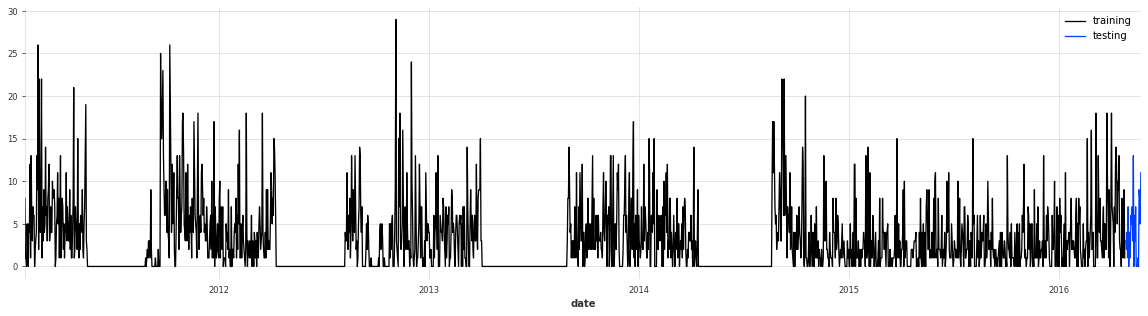

In [5]:
#===== using darts we're using only traditional time series approach ======#
y_train = pd.merge(y_train, X_train[["id","d","date"]].drop_duplicates(), how = "left", on = ["id","d"])
y_test = pd.merge(y_test, X_test[["id","d","date"]].drop_duplicates(), how = "left", on = ["id","d"])
print("TrainShape: ",y_train.shape, " TestShape: ", y_test.shape)
del X_train, X_test
import gc
gc.collect()

#====== y_train, y_test preprocessing ========#
y_train = y_train.sort_values(by = ["id","d"], ascending = True)
y_test = y_test.sort_values(by = ["id","d"], ascending = True)
y_train.set_index("date", inplace = True)
y_test.set_index("date", inplace = True)

# Because we dadd_prefixon't have any hyparparameters in traditional time series modelling we are not splitting into validation instead we are going with 
# train and test dateset 
plt.figure(101, figsize=(20, 5))
y_train[y_train["id"]==41]["sold"].plot(label = "training")
y_test[y_test["id"]==41]["sold"].plot(label = "testing")
plt.legend();

## Seasonality lag Identification

In [6]:
def seasonality_ts(train:pd.Series):
    seas_df = pd.DataFrame([])
    
    for i in train["id"].unique():
        series = TimeSeries.from_series(train[train["id"]==i]["sold"].sort_index(ascending = True))
        ALPHA = 0.05
        for m in range(2, 25):
            is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
            if is_seasonal:
                break

        if is_seasonal:
            df_ses = pd.DataFrame({"Id":[i], "Seasonality_Order":[mseas],"Is_Seasonal":is_seasonal})
            seas_df = pd.concat([seas_df, df_ses], axis = 0)
        else:
            df_ses = pd.DataFrame({"Id":[i], "Seasonality_Order":[0],"Is_Seasonal":is_seasonal})
            seas_df = pd.concat([seas_df, df_ses], axis = 0)
        
    return seas_df

df_seasonal = seasonality_ts(y_train)
df_seasonal.reset_index(drop = True, inplace = True)

## Accuracy Metrics

In [7]:
# compute accuracy metrics and processing time

def accuracy_metrics(model, act, forecast, resid, t_start):
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    from sklearn.metrics import mean_absolute_percentage_error
    res_mape = mean_absolute_percentage_error(np.where(act.pd_series() ==0.0, 0.1, act.pd_series()), forecast.pd_series())
    #res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    res_time = time.perf_counter() - t_start
    
    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {'model': model, "mape":res_mape,"RMSE":res_rmse, "-R squared":-res_r2, 
        "se": res_sefc, "time":res_time}
    return res_accuracy

In [8]:
## fit the chosen forecaster model and compute predictions
def eval_model(model, is_seasonal, mseas, train, val):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    n_val = len(val)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    if model == NaiveDrift():
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()
            

    resid = forecast - val
    res_accuracy = accuracy_metrics(model,val, forecast, resid, t_start)
    
    
    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_accuracy["time"]) + " sec")
    return results

In [9]:
class model_run_traditional_time_series():
    
    def __init__(self, y_train:pd.Series, y_test:pd.Series , is_seasonal:bool, mseas : int):
        self.y_train = y_train
        self.y_test = y_test
        self.is_seasonal = is_seasonal
        self.mseas = mseas
        
    #======= conversion to darts series =========#
    def darts_ts(self):
        series_train = TimeSeries.from_series(self.y_train["sold"].sort_index(ascending = True))
        series_test = TimeSeries.from_series(self.y_test["sold"].sort_index(ascending = True))
        return series_train, series_test
    
    def darts_naive(self):
        m_naive = NaiveDrift()
        result_naive = eval_model(m_naive, is_seasonal = self.is_seasonal, mseas = self.mseas, train = self.series_train, val = self.series_test)
        return result_naive
    
    def darts_prophet(self):
        m_prophet = Prophet()
        result_prophet = eval_model(m_prophet,is_seasonal = self.is_seasonal, mseas = self.mseas, train = self.series_train, val = self.series_test)
        return result_prophet
    
    def darts_exponential(self):
        print(self.is_seasonal)
        if self.is_seasonal == True:
            m_expon = ExponentialSmoothing(seasonal_periods=self.mseas)
        else:
            m_expon = ExponentialSmoothing()
            
        result_expon = eval_model(m_expon,is_seasonal = self.is_seasonal, mseas = self.mseas, train = self.series_train, val = self.series_test) 
        
        return result_expon
    
    def darts_arima(self):
        # prepare ARIMA forecaster
        ALPHA = 0.05
        TRACE = False
        y = np.asarray(self.series_train.pd_series())
        # get order of first differencing: the higher of KPSS and ADF test results
        n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
        n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
        n_diff = max(n_adf, n_kpss)

        # get order of seasonal differencing: the higher of OCSB and CH test results
        n_ocsb = pmd.arima.OCSBTest(m=max(4,self.mseas)).estimate_seasonal_differencing_term(y)
        n_ch = pmd.arima.CHTest(m=max(4,self.mseas)).estimate_seasonal_differencing_term(y)
        ns_diff = max(n_ocsb, n_ch, self.is_seasonal * 1)

        # set up the ARIMA forecaster
        m_arima = AutoARIMA(
            start_p=1, d=n_diff, start_q=1,
            max_p=3, max_d=n_diff, max_q=3,
            start_P=0, D=ns_diff, start_Q=0, m=max(4,self.mseas), seasonal=self.is_seasonal,
            max_P=3, max_D=1, max_Q=3,
            max_order=5,                       # p+q+p+Q <= max_order
            stationary=False, 
            information_criterion="bic", alpha=ALPHA, 
            test="kpss", seasonal_test="ocsb",
            stepwise=True, 
            suppress_warnings=True, error_action="trace", trace=TRACE, with_intercept="auto")
        
        result_arima = eval_model(m_arima,is_seasonal = self.is_seasonal, mseas = self.mseas, train = self.series_train, val = self.series_test) 
        return result_arima
    
    def darts_theta(self):
        
        # search space for best theta value: check 100 alternatives
        thetas = 2 - np.linspace(-10, 10, 100)

        # initialize search
        best_mape = float('inf')
        best_theta = 0
        # search for best theta among 50 values, as measured by MAPE
        for theta in thetas:
            model = Theta(theta,season_mode=SeasonalityMode.ADDITIVE)
            res = model.fit(self.series_train)
            pred_theta = model.predict(len(self.series_test))
            res_mape = rmse(self.series_test, pred_theta)

            if res_mape < best_mape:
                best_mape = res_mape
                best_theta = theta

        m_theta = Theta(best_theta, season_mode=SeasonalityMode.ADDITIVE)   # best theta model among 100
        result_theta = eval_model(m_theta,is_seasonal = self.is_seasonal, mseas = self.mseas, train = self.series_train, val = self.series_test) 
        return result_theta
        
    
    def transform(self):
        # get darts transformed time series
        self.series_train, self.series_test = self.darts_ts()
        # get results for darts naive model
        result_naive = self.darts_naive()
        # get results for darts prophet model
        result_prophet = self.darts_prophet()
        # get results for darts exponential model
        result_expon = self.darts_exponential()
        # get results for darts arima model
        result_arima = self.darts_arima()
        # get results for darts theta model
        result_theta = self.darts_theta()
        
        #========== Accuracy metrics ================#
        result_naive[1].update({"model":"naive"})
        result_prophet[1].update({"model":"prophet"})
        result_expon[1].update({"model":"exponential"})
        result_arima[1].update({"model":"arima"})
        result_theta[1].update({"model":"theta"})

        acc_met = pd.DataFrame([result_naive[1], 
                                result_prophet[1], 
                                result_expon[1], 
                                result_arima[1], 
                                result_theta[1]])
        
        acc_met["id"] = self.y_train["id"].unique()[0]
        
        #========== forecast test ================#
        forecast = pd.concat([result_naive[0].pd_dataframe().rename(columns = {"sold":"naive"}),
                    result_prophet[0].pd_dataframe().rename(columns = {"sold":"prophet"}),
                    result_expon[0].pd_dataframe().rename(columns = {"sold":"exponential"}),
                    result_arima[0].pd_dataframe().rename(columns = {"sold":"arima"}),
                    result_theta[0].pd_dataframe().rename(columns = {"sold":"thetha"})], axis = 1).reset_index()
        forecast["id"] = self.y_train["id"].unique()[0]
        
        return forecast, acc_met

In [10]:
forecast_cmb = pd.DataFrame([])
acc_met_cmb = pd.DataFrame([])
for i in y_train["id"].unique()[0:500]:
    forecast, acc_met = model_run_traditional_time_series(y_train[y_train["id"]==i], 
                                      y_test[y_test["id"]==i], 
                                      df_seasonal[df_seasonal["Id"]==i]["Is_Seasonal"].values[0], 
                                      df_seasonal[df_seasonal["Id"]==i]["Seasonality_Order"].values[0]).transform()
    
    forecast_cmb = pd.concat([forecast_cmb, forecast], axis = 0)
    acc_met_cmb = pd.concat([acc_met_cmb, acc_met], axis = 0)
    print('Combination ',int(list(y_train["id"].unique()).index(i)+1), "of", len(y_train["id"].unique()))

17:45:14 - cmdstanpy - INFO - Chain [1] start processing


beginning: Naive drift model
completed: Naive drift model:0.0405023410000922 sec
beginning: Prophet


17:45:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8322404630000619 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3434575329999916 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.14792566400001 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05778512500000943 sec
Combination  1 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036453926999911346 sec
beginning: Prophet


17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7103652429999556 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33082020400001966 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.059530344 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05469805399991401 sec
Combination  2 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0382568560000891 sec
beginning: Prophet


17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0129815129999997 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3479550129999325 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.93205759800003 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05295407400001295 sec
Combination  3 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037468816000000515 sec
beginning: Prophet


17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7726337279999598 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3319178850000526 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.686937132000025 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05515344599996297 sec
Combination  4 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04220523700007561 sec
beginning: Prophet


17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0976763639999945 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33769539699994766 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.63693173299998 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.055359477000024526 sec
Combination  5 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036693447999937234 sec
beginning: Prophet


17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7585666510000237 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.31449883400000544 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:82.19809749900003 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05568132700000206 sec
Combination  6 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036427967999998145 sec
beginning: Prophet


17:51:32 - cmdstanpy - INFO - Chain [1] start processing
17:51:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7116368929999908 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3233967030000713 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:31.55839923999997 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0554632580000316 sec
Combination  7 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035683729999959724 sec
beginning: Prophet


17:52:08 - cmdstanpy - INFO - Chain [1] start processing
17:52:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0341820369999368 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.30198187399992094 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.17004984099992 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05544792000000598 sec
Combination  8 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03899926000008236 sec
beginning: Prophet


17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7666560299999219 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3107948749998286 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:97.16711814500013 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05279124900016541 sec
Combination  9 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0409540289999768 sec
beginning: Prophet


17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8146898200000123 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3291967850000219 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.84316512800001 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05477027699998871 sec
Combination  10 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03839859799995793 sec
beginning: Prophet


17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2041403880000416 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3262027640000724 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.25161478700011 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0550125869999647 sec
Combination  11 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03578181800003222 sec
beginning: Prophet


17:56:17 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.724138283000002 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3113303539998924 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.55751277299987 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.062028521000002 sec
Combination  12 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03690177400017092 sec
beginning: Prophet


17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7156403449998834 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.31119823400013047 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.17237413700013 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05511537200004568 sec
Combination  13 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036545374000070296 sec
beginning: Prophet


17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1909135549999519 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.33052695100013807 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:34.689935821999825 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05458073200020408 sec
Combination  14 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03812287400000969 sec
beginning: Prophet


17:58:31 - cmdstanpy - INFO - Chain [1] start processing
17:58:31 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8577935040000284 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33492488000001686 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:56.32346453800005 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06237841799998023 sec
Combination  15 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035370158999967316 sec
beginning: Prophet


17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0653426409999156 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3386979979998159 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:93.64302487999998 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05771077800000057 sec
Combination  16 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03598748899980819 sec
beginning: Prophet


18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7241223329999684 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3487486369999715 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.51331405100018 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05921746600006372 sec
Combination  17 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03551071799984129 sec
beginning: Prophet


18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9296900249998998 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33686047599985613 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.41003628499993 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053186912999990454 sec
Combination  18 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03800237399991602 sec
beginning: Prophet


18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.147664733000056 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3298111520000475 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.05759111599991 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05275491200018223 sec
Combination  19 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0371644249999008 sec
beginning: Prophet


18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7504883910000899 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3312484510001923 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.31142349400011 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05311347199994998 sec
Combination  20 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037725733999877775 sec
beginning: Prophet


18:05:05 - cmdstanpy - INFO - Chain [1] start processing
18:05:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7924035440000807 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33803517100000136 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.56381681300013 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05892658100015069 sec
Combination  21 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03589536499998758 sec
beginning: Prophet


18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2218728420000389 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33715205099997547 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:79.25884605200008 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05756559699989339 sec
Combination  22 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03554750800003603 sec
beginning: Prophet


18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0783688609999444 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3345422849999977 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.66041547400005 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05260113700001057 sec
Combination  23 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04206329699991329 sec
beginning: Prophet


18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.686383454999941 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3330025829998249 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:79.02344548699989 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05453047699984381 sec
Combination  24 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038962377999723685 sec
beginning: Prophet


18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2062900180003453 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33190374299965697 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.13409005800031 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.056513447999805067 sec
Combination  25 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04691424700013158 sec
beginning: Prophet


18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7179765830001088 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3369189320001169 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:57.1753120809999 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05039544700002807 sec
Combination  26 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034668667999994796 sec
beginning: Prophet


18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8805517750001854 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.352550772000086 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.06501387000026 sec
beginning: Theta(1.0909090909090917)
completed: Theta(1.0909090909090917):0.054393617999721755 sec
Combination  27 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03859193800008143 sec
beginning: Prophet


18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0456646120001096 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3268592490003357 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.58803696599989 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05727493799986405 sec
Combination  28 of 4170
beginning: Naive drift model
completed: Naive drift model:0.040380619000188744 sec
beginning: Prophet


18:13:59 - cmdstanpy - INFO - Chain [1] start processing
18:13:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7968729119997988 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3293123180001203 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:78.39478156899986 sec
beginning: Theta(0.6868686868686869)
completed: Theta(0.6868686868686869):0.0563347980000799 sec
Combination  29 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0403727190000609 sec
beginning: Prophet


18:15:22 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2319343240001217 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3141059790000327 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.99086228099986 sec
beginning: Theta(-1.333333333333334)
completed: Theta(-1.333333333333334):0.05753676699987409 sec
Combination  30 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03632825900012904 sec
beginning: Prophet


18:16:30 - cmdstanpy - INFO - Chain [1] start processing
18:16:31 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7239701869998498 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.31378968599983637 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.88971230700008 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05710059800003364 sec
Combination  31 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03815198899974348 sec
beginning: Prophet


18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8601244720002796 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3291333850002047 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.84511041099995 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05562386800011154 sec
Combination  32 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03675087800002075 sec
beginning: Prophet


18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1290406090001852 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3294943560003958 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.81135663199984 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.06486908700026106 sec
Combination  33 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03613790899999003 sec
beginning: Prophet


18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7243234669999765 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33250659500026813 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:91.33482350800023 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05237229800013665 sec
Combination  34 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036884238999846275 sec
beginning: Prophet


18:20:25 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8580379410000205 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33874278500024957 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.68073529200001 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.059004105999974854 sec
Combination  35 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039558988000408135 sec
beginning: Prophet


18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0784232959999827 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33979642900021645 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.34712099199987 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05682138699967254 sec
Combination  36 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03674291800007268 sec
beginning: Prophet


18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8071948619999603 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3257373309998002 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.56586324900036 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05245996699977695 sec
Combination  37 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037371427999914886 sec
beginning: Prophet


18:23:09 - cmdstanpy - INFO - Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8166265410000051 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.352192149000075 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.78145036499973 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06438377599988598 sec
Combination  38 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03588912799978061 sec
beginning: Prophet


18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:24:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7980589520002468 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9:0.3467895899998439 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:108.72926303299982 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05336901700002272 sec
Combination  39 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03583768799990139 sec
beginning: Prophet


18:26:10 - cmdstanpy - INFO - Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8339989400001286 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3406236800001352 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:88.0663644909996 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05392154700030005 sec
Combination  40 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03437021799982176 sec
beginning: Prophet


18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1515683509996961 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32797489999984464 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.21203829700016 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05564967700001944 sec
Combination  41 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03740414799995051 sec
beginning: Prophet


18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8560378590000255 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32831780099968455 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:72.81755107400022 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.055664155000158644 sec
Combination  42 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034453697000117245 sec
beginning: Prophet


18:30:03 - cmdstanpy - INFO - Chain [1] start processing
18:30:03 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7926693090003027 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.327933493999808 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.31085162499994 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05946373599999788 sec
Combination  43 of 4170
beginning: Naive drift model
completed: Naive drift model:0.041828106999673764 sec
beginning: Prophet


18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9903452540002036 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3314839650001886 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.27822639799979 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052186836000146286 sec
Combination  44 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03833568699974421 sec
beginning: Prophet


18:32:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.784298119000141 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33650646399973994 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.358901334000166 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054837454999869806 sec
Combination  45 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03666932699979952 sec
beginning: Prophet


18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7164357440001368 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3430374839999786 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.22265129200014 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05572509600006015 sec
Combination  46 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04042523699990852 sec
beginning: Prophet


18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.221418464999715 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3434448129996781 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.34646022299967 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06056286499961061 sec
Combination  47 of 4170
beginning: Naive drift model


18:35:33 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.04067303699957847 sec
beginning: Prophet


18:35:33 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7754316499999732 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3446983040003033 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:86.30640816100004 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05350996600009239 sec
Combination  48 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039677197000401065 sec
beginning: Prophet


18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1055570640000951 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32566726499999277 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.667675119999785 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05519915599961678 sec
Combination  49 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03568832700011626 sec
beginning: Prophet


18:37:46 - cmdstanpy - INFO - Chain [1] start processing
18:37:47 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8648341040002379 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3364077340002041 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:92.76346130299999 sec
beginning: Theta(0.6868686868686869)
completed: Theta(0.6868686868686869):0.05184349699993618 sec
Combination  50 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03574866700000712 sec
beginning: Prophet


18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:24 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7921163119999619 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3064322320001338 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.30964245999985 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.04967054700000517 sec
Combination  51 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036810657999922114 sec
beginning: Prophet


18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9990877600002932 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14:0.30423633200007316 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:192.09395649099952 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055619545999434195 sec
Combination  52 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03541966800003138 sec
beginning: Prophet


18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.727703706000284 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14:0.3077706220001346 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:278.1406761400003 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051426703999823076 sec
Combination  53 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036572544999216916 sec
beginning: Prophet


18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:48:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7090692410001793 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.2819088639998881 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:29.18138250100037 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05456827299985889 sec
Combination  54 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034724864999589045 sec
beginning: Prophet


18:49:01 - cmdstanpy - INFO - Chain [1] start processing
18:49:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9249503130004086 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=10
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=10:0.30400202199962223 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:148.9638733799993 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053159374000642856 sec
Combination  55 of 4170
beginning: Naive drift model


18:51:35 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.047106214000450564 sec
beginning: Prophet


18:51:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7399883059997592 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.2981299029997899 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.126717627999824 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05248058300003322 sec
Combination  56 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03788391499983845 sec
beginning: Prophet


18:52:41 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0433880880000288 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.29523844300001656 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:207.20212094400085 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05341951699938363 sec
Combination  57 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034168147999480425 sec
beginning: Prophet


18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7077466970004025 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.29158643299979303 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.33111638599985 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05049380700074835 sec
Combination  58 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038090527999884216 sec
beginning: Prophet


18:57:16 - cmdstanpy - INFO - Chain [1] start processing
18:57:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7189795759995832 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=10
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=10:0.29496868299975176 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:150.0919599380004 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.050770687000294856 sec
Combination  59 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03775171699999191 sec
beginning: Prophet


18:59:50 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1888266980004119 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.30162859200027015 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:197.05661790700015 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055236896000678826 sec
Combination  60 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03739148800013936 sec
beginning: Prophet


19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8257458099997166 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.3471114089998082 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:286.8990722560002 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.055234956000276725 sec
Combination  61 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03776776799986692 sec
beginning: Prophet


19:08:04 - cmdstanpy - INFO - Chain [1] start processing
19:08:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.965835815999526 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.35300704699966445 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.55721372900007 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05651145599949814 sec
Combination  62 of 4170
beginning: Naive drift model
completed: Naive drift model:0.040246116999696824 sec
beginning: Prophet


19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2406205679999402 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3343716070003211 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.152417303999755 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.060726206000254024 sec
Combination  63 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0391500569994605 sec
beginning: Prophet


19:10:24 - cmdstanpy - INFO - Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7454780510006458 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3470654070006276 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.517011963000186 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05908818599982624 sec
Combination  64 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03567429699978675 sec
beginning: Prophet


19:11:16 - cmdstanpy - INFO - Chain [1] start processing
19:11:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.74946731 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34164574700025696 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.99608065099983 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053009256000223104 sec
Combination  65 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03642677800053207 sec
beginning: Prophet


19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8067628559992954 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.353347606999705 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.845686482999554 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05284841699995013 sec
Combination  66 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0378051180005059 sec
beginning: Prophet


19:13:54 - cmdstanpy - INFO - Chain [1] start processing
19:13:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9542533369994999 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3287223779998385 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:91.27743002500029 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05628139599957649 sec
Combination  67 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03856147700025758 sec
beginning: Prophet


19:15:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1993819399995118 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33340752799995244 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.04072148100022 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051353967000068224 sec
Combination  68 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03431308700055524 sec
beginning: Prophet


19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7882592579999255 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3274086179999358 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.91226519999964 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053463257000657904 sec
Combination  69 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03543292799986375 sec
beginning: Prophet


19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8844513309995818 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32877030899999227 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.6417759599999 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0558013360005134 sec
Combination  70 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04044344700014335 sec
beginning: Prophet


19:18:30 - cmdstanpy - INFO - Chain [1] start processing
19:18:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2328788069999064 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33181311699991056 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:92.11401803800072 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05478418699931353 sec
Combination  71 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036598778000552556 sec
beginning: Prophet


19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8277170239998668 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3295701880006163 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:161.6761773170001 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05731158599974151 sec
Combination  72 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04001177700047265 sec
beginning: Prophet


19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8069777639993845 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3291381179997188 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.07016474699958 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.058602787000381795 sec
Combination  73 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03736815699994622 sec
beginning: Prophet


19:24:06 - cmdstanpy - INFO - Chain [1] start processing
19:24:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2942991509999047 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32756782799970097 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.31140882900036 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054581385999881604 sec
Combination  74 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04271542800051975 sec
beginning: Prophet


19:25:05 - cmdstanpy - INFO - Chain [1] start processing
19:25:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9023084189993824 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3435812759998953 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.699284280999564 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05238233599993691 sec
Combination  75 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03525997699944128 sec
beginning: Prophet


19:26:09 - cmdstanpy - INFO - Chain [1] start processing
19:26:09 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.768141246999221 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3303357579998192 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.54918401199939 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06169155600036902 sec
Combination  76 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03950943800009554 sec
beginning: Prophet


19:26:55 - cmdstanpy - INFO - Chain [1] start processing
19:26:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0994590939999398 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.2998953599999368 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.06239564599946 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05560592599977099 sec
Combination  77 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0372165179996955 sec
beginning: Prophet


19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8488396019993161 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3774923040000431 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.71624680600053 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.07854081400000723 sec
Combination  78 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035996947000057844 sec
beginning: Prophet


19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.228373425999962 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3319521869998425 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.17912215599972 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05871933600064949 sec
Combination  79 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037706477000028826 sec
beginning: Prophet


19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8155016540003999 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.37309962499966787 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.1462786839993 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05569607600045856 sec
Combination  80 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04382503700071538 sec
beginning: Prophet


19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.848468633000266 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3414727870003844 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:65.87700255799973 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.057840026000121725 sec
Combination  81 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035922148000281595 sec
beginning: Prophet


19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1572534619999715 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33741803700013406 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:152.57010542999978 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.053699176000009174 sec
Combination  82 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04187257699959446 sec
beginning: Prophet


19:33:50 - cmdstanpy - INFO - Chain [1] start processing
19:33:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8708289699998204 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3375608670003203 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:101.78386798799966 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054055597000115085 sec
Combination  83 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03973343699999532 sec
beginning: Prophet


19:35:37 - cmdstanpy - INFO - Chain [1] start processing
19:35:37 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8617979109994849 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3372924069999499 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.410881712000446 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05366726699958235 sec
Combination  84 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036564507000548474 sec
beginning: Prophet


19:36:35 - cmdstanpy - INFO - Chain [1] start processing
19:36:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1815082889997939 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14:0.3265074179998919 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:390.59137850800016 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.060028705000149785 sec
Combination  85 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03510841699971934 sec
beginning: Prophet


19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.023323313000219 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.2943406149997827 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.24237264099975 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0533464649997768 sec
Combination  86 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03652344699912646 sec
beginning: Prophet


19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7820692139994208 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.2943987449998531 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:82.37183270500009 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05429220499991061 sec
Combination  87 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03523694700015767 sec
beginning: Prophet


19:45:42 - cmdstanpy - INFO - Chain [1] start processing
19:45:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0285914730002332 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.29099965499972313 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.94702971300012 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05631838500084996 sec
Combination  88 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03485618699960469 sec
beginning: Prophet


19:46:28 - cmdstanpy - INFO - Chain [1] start processing
19:46:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8644808369999737 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.306812283999534 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:263.734579465 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05644214499989175 sec
Combination  89 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035229707000326016 sec
beginning: Prophet


19:50:57 - cmdstanpy - INFO - Chain [1] start processing
19:50:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7981044119997023 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.298728624999967 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:132.47605825899973 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.057421434999923804 sec
Combination  90 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03974372599986964 sec
beginning: Prophet


19:53:19 - cmdstanpy - INFO - Chain [1] start processing
19:53:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0926023269985308 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9:0.31380342400007066 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:128.5383301820002 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.056829146000382025 sec
Combination  91 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038720467000530334 sec
beginning: Prophet


19:55:32 - cmdstanpy - INFO - Chain [1] start processing
19:55:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7521409170003608 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.312738973998421 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:216.59466458799943 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05753908500082616 sec
Combination  92 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0369485569990502 sec
beginning: Prophet


19:59:13 - cmdstanpy - INFO - Chain [1] start processing
19:59:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2287318960006814 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.2915636050001922 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:69.86632592599926 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05584519600051863 sec
Combination  93 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03753368700017745 sec
beginning: Prophet


20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9065058140004112 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3228358719989046 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.93895104400144 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0605199450001237 sec
Combination  94 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036592555999959586 sec
beginning: Prophet


20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:17 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8114264320010989 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33831406099852757 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.5134564330001 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05634947599901352 sec
Combination  95 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03642581599888217 sec
beginning: Prophet


20:02:19 - cmdstanpy - INFO - Chain [1] start processing
20:02:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0417563920000248 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33214313200005563 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.89335320800092 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05530590600028518 sec
Combination  96 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03787101600028109 sec
beginning: Prophet


20:03:10 - cmdstanpy - INFO - Chain [1] start processing
20:03:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8187493400000676 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33664598199902684 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.80198234999989 sec
beginning: Theta(3.717171717171718)
completed: Theta(3.717171717171718):0.05461813500005519 sec
Combination  97 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036202397001034115 sec
beginning: Prophet


20:04:00 - cmdstanpy - INFO - Chain [1] start processing
20:04:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8020689819986728 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33599848199992266 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.963600416998815 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05522235600074055 sec
Combination  98 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03706561699982558 sec
beginning: Prophet


20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9966218859990477 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32556764199944155 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.39828428799956 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.061777083999913884 sec
Combination  99 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038366126998880645 sec
beginning: Prophet


20:05:46 - cmdstanpy - INFO - Chain [1] start processing
20:05:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7584557860009227 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.34606679999888 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.51340980299938 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05368898599954264 sec
Combination  100 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03720331800104759 sec
beginning: Prophet


20:06:50 - cmdstanpy - INFO - Chain [1] start processing
20:06:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2216233359995385 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.34838557100010803 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.48471237500053 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05174870600058057 sec
Combination  101 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04086280599949532 sec
beginning: Prophet


20:07:35 - cmdstanpy - INFO - Chain [1] start processing
20:07:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7856313539996336 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3290235020012915 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:57.78799515399987 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.057594095000240486 sec
Combination  102 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03621185599877208 sec
beginning: Prophet


20:08:38 - cmdstanpy - INFO - Chain [1] start processing
20:08:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7078991910002514 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3287859819993173 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.61952069199833 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.056144354999560164 sec
Combination  103 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03812097700028971 sec
beginning: Prophet


20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0283289430008153 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33070482200128026 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.79304200899969 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.058304534999479074 sec
Combination  104 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03636945600010222 sec
beginning: Prophet


20:10:39 - cmdstanpy - INFO - Chain [1] start processing
20:10:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8412795889998961 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33248813200043514 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:74.08109508000052 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05593475499881606 sec
Combination  105 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03628029699939361 sec
beginning: Prophet


20:11:57 - cmdstanpy - INFO - Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.772094455000115 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32710806200157094 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:77.85691196400148 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05691784600094252 sec
Combination  106 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03649390800092078 sec
beginning: Prophet


20:13:20 - cmdstanpy - INFO - Chain [1] start processing
20:13:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9995008429996233 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33219798400023137 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.457585125999685 sec
beginning: Theta(4.929292929292929)
completed: Theta(4.929292929292929):0.052361165999172954 sec
Combination  107 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03469721700093942 sec
beginning: Prophet


20:14:20 - cmdstanpy - INFO - Chain [1] start processing
20:14:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7620577920006326 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33153079400108254 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.46098695999899 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05876806599917472 sec
Combination  108 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03799419699862483 sec
beginning: Prophet


20:15:08 - cmdstanpy - INFO - Chain [1] start processing
20:15:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9903026140000293 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3325044640005217 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.36163201300042 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05504779600050824 sec
Combination  109 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038355287000740645 sec
beginning: Prophet


20:15:58 - cmdstanpy - INFO - Chain [1] start processing
20:15:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8000825780000014 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33338169399939943 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.29084752200106 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052813895999861415 sec
Combination  110 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034923938001156785 sec
beginning: Prophet


20:16:49 - cmdstanpy - INFO - Chain [1] start processing
20:16:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7638646209998115 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3290797739991831 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.062861521999366 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05329866600004607 sec
Combination  111 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03601384699868504 sec
beginning: Prophet


20:17:34 - cmdstanpy - INFO - Chain [1] start processing
20:17:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1991016270003456 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3353948349995335 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:80.37654050400124 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05768924600124592 sec
Combination  112 of 4170
beginning: Naive drift model
completed: Naive drift model:0.041825415999483084 sec
beginning: Prophet


20:18:59 - cmdstanpy - INFO - Chain [1] start processing
20:18:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8158900660000654 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3359031429990864 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.21138534099919 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052611856001021806 sec
Combination  113 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035963727001217194 sec
beginning: Prophet


20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6951495360008266 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3376596240013896 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.33288723899932 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05396420499891974 sec
Combination  114 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03501279699958104 sec
beginning: Prophet


20:21:16 - cmdstanpy - INFO - Chain [1] start processing
20:21:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7683650799990573 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33984960399902775 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.49175021500014 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05511681600000884 sec
Combination  115 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03679367699987779 sec
beginning: Prophet


20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8432740150001337 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3367299340006866 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.57649779800158 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.060521874998812564 sec
Combination  116 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03760617799889587 sec
beginning: Prophet


20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0041344230012328 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32719828500012227 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:77.67190790300083 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05716400600067573 sec
Combination  117 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037112517000423395 sec
beginning: Prophet


20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8930290210009844 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3425688530005573 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.21820437399947 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.06130574499911745 sec
Combination  118 of 4170
beginning: Naive drift model


20:26:06 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.04228026599957957 sec
beginning: Prophet


20:26:06 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.976872605000608 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3297296140008257 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.72995210999943 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054049385000325856 sec
Combination  119 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034902577001048485 sec
beginning: Prophet


20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1671027300017158 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33384992399987823 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.990327849000096 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.057174544999725185 sec
Combination  120 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035962066998763476 sec
beginning: Prophet


20:28:07 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7193338650013175 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3305966340012674 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:65.30433598700074 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05771187499885855 sec
Combination  121 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037401027000669274 sec
beginning: Prophet


20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8776873320002778 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33903798400024243 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:86.89181420000023 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0556681350008148 sec
Combination  122 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034499507000873564 sec
beginning: Prophet


20:30:49 - cmdstanpy - INFO - Chain [1] start processing
20:30:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.3262466430005588 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3263342439986445 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.2783796470012 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.056562425999800325 sec
Combination  123 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0355539480005973 sec
beginning: Prophet


20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.958881892998761 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3464483520001522 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.90650227099832 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.049132415999338264 sec
Combination  124 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03910061700116785 sec
beginning: Prophet


20:32:52 - cmdstanpy - INFO - Chain [1] start processing
20:32:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9969825389998732 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3424342029993568 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.743996856001104 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05602914600058284 sec
Combination  125 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03892185699987749 sec
beginning: Prophet


20:33:57 - cmdstanpy - INFO - Chain [1] start processing
20:33:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9035490869991918 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3291165329992509 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.97231730599924 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.057259985000200686 sec
Combination  126 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03662062699913804 sec
beginning: Prophet


20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8545949809995363 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.329394754000532 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.26966063600048 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05373353600043629 sec
Combination  127 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03577129800032708 sec
beginning: Prophet


20:35:40 - cmdstanpy - INFO - Chain [1] start processing
20:35:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.094439943000907 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3336409930016089 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.75332402700042 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05673146599838219 sec
Combination  128 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03594428699943819 sec
beginning: Prophet


20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8556786710014421 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3578307709994988 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.04584848900049 sec
beginning: Theta(-1.333333333333334)
completed: Theta(-1.333333333333334):0.05438267600038671 sec
Combination  129 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03875098600110505 sec
beginning: Prophet


20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7110843319987907 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3270667830001912 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.232250483000826 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0536382259997481 sec
Combination  130 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034396257000480546 sec
beginning: Prophet


20:38:16 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.052984046000347 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.31359686399991915 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.687847829998645 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05268702600005781 sec
Combination  131 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03623476699976891 sec
beginning: Prophet


20:38:57 - cmdstanpy - INFO - Chain [1] start processing
20:38:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7815191770005185 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3115557550008816 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:49.2922097160008 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05285574600020482 sec
Combination  132 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036324556998806656 sec
beginning: Prophet


20:39:51 - cmdstanpy - INFO - Chain [1] start processing
20:39:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6926408639992587 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.31096813499971176 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.47686111400071 sec
beginning: Theta(-7.595959595959595)
completed: Theta(-7.595959595959595):0.058825285001148586 sec
Combination  133 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03535259700038296 sec
beginning: Prophet


20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0413220360005653 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3073797859997285 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.55929033800021 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0594790049999574 sec
Combination  134 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03708369700143521 sec
beginning: Prophet


20:41:24 - cmdstanpy - INFO - Chain [1] start processing
20:41:24 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7878718369993294 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.322797894001269 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.93783274700036 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05312709600002563 sec
Combination  135 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0409859770006733 sec
beginning: Prophet


20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7691743979994499 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9:0.33032395300142525 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.40684839099958 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05486865499915439 sec
Combination  136 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03654506800012314 sec
beginning: Prophet


20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0523886150003818 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3139605640008085 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.12669526600075 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06093585500093468 sec
Combination  137 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03447837699968659 sec
beginning: Prophet


20:44:22 - cmdstanpy - INFO - Chain [1] start processing
20:44:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8629835200008529 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3312925640002504 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.67193493200102 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05480934500155854 sec
Combination  138 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03746649700042326 sec
beginning: Prophet


20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8307438840001851 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.335903072000292 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.817326542000956 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05507542599843873 sec
Combination  139 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03656629800025257 sec
beginning: Prophet


20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8030355760001839 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33122907299912185 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.46276360400043 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0560474450012407 sec
Combination  140 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03822834699894884 sec
beginning: Prophet


20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.80280365499857 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3394159720010066 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.01382461399953 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053765182999995886 sec
Combination  141 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036606134999601636 sec
beginning: Prophet


20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0192602070001158 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3292133439990721 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:75.55540995600131 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0535255140002846 sec
Combination  142 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03751553599977342 sec
beginning: Prophet


20:49:18 - cmdstanpy - INFO - Chain [1] start processing
20:49:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7512707370005955 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3311736440009554 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.56505488899893 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05358811400037666 sec
Combination  143 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03913316599937389 sec
beginning: Prophet


20:50:08 - cmdstanpy - INFO - Chain [1] start processing
20:50:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7893582730011985 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32502965399908135 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.776563116000034 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05385230399951979 sec
Combination  144 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03519710700129508 sec
beginning: Prophet


20:51:01 - cmdstanpy - INFO - Chain [1] start processing
20:51:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.071259211999859 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3298903730010352 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:81.62721163700007 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.053513864000706235 sec
Combination  145 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03708361600001808 sec
beginning: Prophet


20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8061422810005752 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33224193299975013 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:51.86922626500018 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053503433999139816 sec
Combination  146 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039339156001005904 sec
beginning: Prophet


20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.989185381000425 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3363705129995651 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.55686312999933 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053861004000282264 sec
Combination  147 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03603570599989325 sec
beginning: Prophet


20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.077502751000793 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3386794830003055 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.71303993199945 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05791754399979254 sec
Combination  148 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037062245999550214 sec
beginning: Prophet


20:55:19 - cmdstanpy - INFO - Chain [1] start processing
20:55:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7689287850007531 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33987185300065903 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:94.72368830400046 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051426383999569225 sec
Combination  149 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03365351600041322 sec
beginning: Prophet


20:56:58 - cmdstanpy - INFO - Chain [1] start processing
20:56:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1484183630000189 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3354393030003848 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.19263427799888 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05191594399911992 sec
Combination  150 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03363840599922696 sec
beginning: Prophet


20:58:07 - cmdstanpy - INFO - Chain [1] start processing
20:58:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7197296009999263 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3263721440016525 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:69.65772082700096 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05568703400058439 sec
Combination  151 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0366863960007322 sec
beginning: Prophet


20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.812506921000022 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.34344494200013287 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:82.72760358599953 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05965449399991485 sec
Combination  152 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0385688049991586 sec
beginning: Prophet


21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0531523039990134 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3410216930005845 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:65.5753225039989 sec
beginning: Theta(1.8989898989898997)
completed: Theta(1.8989898989898997):0.05526722299873654 sec
Combination  153 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03494866600158275 sec
beginning: Prophet


21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9220011279994651 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.332599723000385 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.824282589001086 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05312026599858655 sec
Combination  154 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03593230700062122 sec
beginning: Prophet


21:02:49 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7929003930003091 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32339160599985917 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.35860687400054 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054216356000324595 sec
Combination  155 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03444584800126904 sec
beginning: Prophet


21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9780469189990981 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33134084599987546 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:73.34762466199936 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051759515999947325 sec
Combination  156 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037429187999805436 sec
beginning: Prophet


21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7880848130007507 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3283162560001074 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.91300619899994 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054395556000599754 sec
Combination  157 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03822691700042924 sec
beginning: Prophet


21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7836662520003301 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.2887566079989483 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:90.16084751000017 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05114165600025444 sec
Combination  158 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038774607000959804 sec
beginning: Prophet


21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9554929189998802 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.29117421899900364 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.09983367999848 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05399026600025536 sec
Combination  159 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0358213479994447 sec
beginning: Prophet


21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8992489640004351 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.2940845579996676 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:79.9724955239999 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05269016600141185 sec
Combination  160 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036886697000227286 sec
beginning: Prophet


21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1258282169983431 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.29726549800034263 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:93.45508550600061 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05388727599893173 sec
Combination  161 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03346958799920685 sec
beginning: Prophet


21:11:50 - cmdstanpy - INFO - Chain [1] start processing
21:11:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7588944740000443 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.29136673900029564 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:310.9631301219997 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05367797600047197 sec
Combination  162 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036206046999723185 sec
beginning: Prophet


21:17:05 - cmdstanpy - INFO - Chain [1] start processing
21:17:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7539882639994175 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.28909899899917946 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.42479017000005 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054473055999551434 sec
Combination  163 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04047798700048588 sec
beginning: Prophet


21:17:45 - cmdstanpy - INFO - Chain [1] start processing
21:17:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0445186630004173 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.29416245900029026 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.808325021998826 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.051204796000092756 sec
Combination  164 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03671421699982602 sec
beginning: Prophet


21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7505840850008099 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.28144122900084767 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.27900851300001 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.060226056000828976 sec
Combination  165 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03901506699912716 sec
beginning: Prophet


21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7707503630008432 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.29818765799973335 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.47638254699996 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05083265600114828 sec
Combination  166 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036141978000159725 sec
beginning: Prophet


21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9988228460006212 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.2892250389995752 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:57.573840761999236 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.060262126000452554 sec
Combination  167 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04134029699889652 sec
beginning: Prophet


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7539185139994515 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34333415499895636 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.600215327000114 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05829548600013368 sec
Combination  168 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03512698799931968 sec
beginning: Prophet


21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0062691240000277 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32605883500036725 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.01093192999906 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052824854999926174 sec
Combination  169 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03823139700034517 sec
beginning: Prophet


21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6895070570008102 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3399603349989775 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.780745461999686 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05858947500018985 sec
Combination  170 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0364400670005125 sec
beginning: Prophet


21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.75265709300038 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.2884468880001805 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.36661730600099 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05428445600045961 sec
Combination  171 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04015386700120871 sec
beginning: Prophet


21:25:02 - cmdstanpy - INFO - Chain [1] start processing
21:25:02 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9852864060012507 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.2910037370002101 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.395472885000345 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.04968209700018633 sec
Combination  172 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035838008001519484 sec
beginning: Prophet


21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7803511809997872 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.282015077998949 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.333989115000804 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05604974599918933 sec
Combination  173 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03870227700099349 sec
beginning: Prophet


21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7189937860002829 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.2859219279998797 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.190220485999816 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05158622599992668 sec
Combination  174 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035908027000914444 sec
beginning: Prophet


21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.050855481000326 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.28625547800038476 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:84.70072589299889 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05276938600036374 sec
Combination  175 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03709849699953338 sec
beginning: Prophet


21:28:37 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6954889070002537 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.2807371590006369 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:32.63203729499946 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05237039600069693 sec
Combination  176 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038026796999474755 sec
beginning: Prophet


21:29:14 - cmdstanpy - INFO - Chain [1] start processing
21:29:14 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6904506379996747 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3383425450010691 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.57026254100128 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05881156499890494 sec
Combination  177 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03337124700010463 sec
beginning: Prophet


21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.083383638999294 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3296753849990637 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.86906726900088 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05328092600029777 sec
Combination  178 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0347806669997226 sec
beginning: Prophet


21:31:12 - cmdstanpy - INFO - Chain [1] start processing
21:31:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9671811970001727 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3290843049999239 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.203309647000424 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05733191500075918 sec
Combination  179 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034962128000188386 sec
beginning: Prophet


21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8850262329997349 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3272440660002758 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:34.096554414998536 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05409110599975975 sec
Combination  180 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03675042699978803 sec
beginning: Prophet


21:32:38 - cmdstanpy - INFO - Chain [1] start processing
21:32:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.073534908999136 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33885289399950125 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.65008422400024 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.062472104998960276 sec
Combination  181 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03785419700034254 sec
beginning: Prophet


21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7958942800014484 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3375692740009981 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.76873018800143 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05507248600042658 sec
Combination  182 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03611733700017794 sec
beginning: Prophet


21:34:45 - cmdstanpy - INFO - Chain [1] start processing
21:34:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.3907662450001226 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3320096650004416 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.90160180800012 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05495203600003151 sec
Combination  183 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036878426999464864 sec
beginning: Prophet


21:35:37 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8596881749999739 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3428622240007826 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.69242600299913 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.054562885999985156 sec
Combination  184 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035172017000149935 sec
beginning: Prophet


21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8471695260013803 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9:0.3356942850004998 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:105.98687752899968 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.050238635998539394 sec
Combination  185 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03423399699931906 sec
beginning: Prophet


21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0219337540002016 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33031331499842054 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.488528345000304 sec
beginning: Theta(-0.7272727272727266)
completed: Theta(-0.7272727272727266):0.06191494499944383 sec
Combination  186 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037372246999439085 sec
beginning: Prophet


21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7697976519993972 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3335522640009003 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.10359213799893 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.057874574999004835 sec
Combination  187 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03566146700177342 sec
beginning: Prophet


21:40:34 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8038363409996236 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32887740200021653 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.24954176199935 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054540986000574776 sec
Combination  188 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03433009699983813 sec
beginning: Prophet


21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9264640610017523 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3297163709994493 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.83101307099969 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05215885600046022 sec
Combination  189 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036528905999148265 sec
beginning: Prophet


21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8236531900001864 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3289668819998042 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.85322352299954 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.050880376000350225 sec
Combination  190 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037287137000021175 sec
beginning: Prophet


21:43:10 - cmdstanpy - INFO - Chain [1] start processing
21:43:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9452111190003052 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32326074299999163 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.07930997299991 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053170135000982555 sec
Combination  191 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035484956999425776 sec
beginning: Prophet


21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0673450890008098 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.32795570100097393 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.36982454200006 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05505633500069962 sec
Combination  192 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03784117599934689 sec
beginning: Prophet


21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.812905000999308 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33275622200017096 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.37185254799988 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053161365000050864 sec
Combination  193 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035491717000695644 sec
beginning: Prophet


21:45:52 - cmdstanpy - INFO - Chain [1] start processing
21:45:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6921718009998585 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33172469200144405 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.289557025998874 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05042726600004244 sec
Combination  194 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03855795600065903 sec
beginning: Prophet


21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0396422909998364 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33288291200005915 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.97323207699992 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05391917500128329 sec
Combination  195 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0364842970011523 sec
beginning: Prophet


21:47:58 - cmdstanpy - INFO - Chain [1] start processing
21:47:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7005481100004545 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32802471200011496 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.87705157700111 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0531204249982693 sec
Combination  196 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036962317000870826 sec
beginning: Prophet


21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0344733419988188 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3269315920006193 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.1733091699989 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06171738500052015 sec
Combination  197 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038984156999504194 sec
beginning: Prophet


21:49:39 - cmdstanpy - INFO - Chain [1] start processing
21:49:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8759771060013009 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33903237099912076 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.27068763900024 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05337072600013926 sec
Combination  198 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03621241600012581 sec
beginning: Prophet


21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.787759652999739 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3331766709998192 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:86.78429647700068 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052294425999207306 sec
Combination  199 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03994566599976679 sec
beginning: Prophet


21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0338132420001784 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3323616409998067 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.946063045999836 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05295884599945566 sec
Combination  200 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035857566001141095 sec
beginning: Prophet


21:53:11 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7442660070009879 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3416984109990153 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.034740232998956 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05319897499975923 sec
Combination  201 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03699222700015525 sec
beginning: Prophet


21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7956121719998919 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32853060200068285 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.54705977500089 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05241868600023736 sec
Combination  202 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03657256699989375 sec
beginning: Prophet


21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0040619840001455 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32698313199944096 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.519307390000904 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05517951599904336 sec
Combination  203 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03423581800052489 sec
beginning: Prophet


21:55:55 - cmdstanpy - INFO - Chain [1] start processing
21:55:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.955281358999855 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33077663199946983 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.000068495999585 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054765474998930586 sec
Combination  204 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034776667000187445 sec
beginning: Prophet


21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7168780989995867 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3346817509991524 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.85473929 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.06365321500015853 sec
Combination  205 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03556573700006993 sec
beginning: Prophet


21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0631339480005408 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3232327349996922 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:86.57544005099953 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05234952599857934 sec
Combination  206 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0348495569996885 sec
beginning: Prophet


21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:24 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8111854380003933 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32847347399911087 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:74.5304366190012 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05472484500023711 sec
Combination  207 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03917040699889185 sec
beginning: Prophet


22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.065163338000275 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3264368740001373 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.11800592700092 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05737723499987624 sec
Combination  208 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03547653699934017 sec
beginning: Prophet


22:01:26 - cmdstanpy - INFO - Chain [1] start processing
22:01:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7898109390007448 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14:0.33965007299957506 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:474.2180631190022 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.058053475000633625 sec
Combination  209 of 4170
beginning: Naive drift model


22:09:25 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.03962618700097664 sec
beginning: Prophet


22:09:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7643749509988993 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.32888940400152933 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.76436219799871 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05384038600095664 sec
Combination  210 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036541617002512794 sec
beginning: Prophet


22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0944110060008825 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3309197150010732 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.11651100800009 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05726908599899616 sec
Combination  211 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035504357001627795 sec
beginning: Prophet


22:10:50 - cmdstanpy - INFO - Chain [1] start processing
22:10:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7789594000023499 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3266383539994422 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.67050323099829 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05698807599765132 sec
Combination  212 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03813534700020682 sec
beginning: Prophet


22:12:03 - cmdstanpy - INFO - Chain [1] start processing
22:12:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7692449209971528 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32842889500170713 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.26851430399984 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05416391600010684 sec
Combination  213 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03577693700208329 sec
beginning: Prophet


22:13:10 - cmdstanpy - INFO - Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.118547182999464 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3267700350006635 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.05628436700135 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05570647599961376 sec
Combination  214 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04453483600082109 sec
beginning: Prophet


22:14:17 - cmdstanpy - INFO - Chain [1] start processing
22:14:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9537571870023385 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3386220639986277 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.97192242899837 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05346545599968522 sec
Combination  215 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03534873700118624 sec
beginning: Prophet


22:15:25 - cmdstanpy - INFO - Chain [1] start processing
22:15:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0635460689991305 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3312360449999687 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.86722599399945 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.057462736000161385 sec
Combination  216 of 4170
beginning: Naive drift model
completed: Naive drift model:0.040473387001839 sec
beginning: Prophet


22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8372156859986717 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33478779399956693 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.00435527599984 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.054257765998045215 sec
Combination  217 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03687776700098766 sec
beginning: Prophet


22:17:31 - cmdstanpy - INFO - Chain [1] start processing
22:17:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7826455709982838 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.30561027599833324 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.18351947799965 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05409811600111425 sec
Combination  218 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03642138699797215 sec
beginning: Prophet


22:18:18 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1630716209983802 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.30817654600105016 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.01901053199981 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05447549599921331 sec
Combination  219 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035265256999991834 sec
beginning: Prophet


22:19:00 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8448604860022897 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3142280659994867 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.71035324799959 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052567175996955484 sec
Combination  220 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03865773700090358 sec
beginning: Prophet


22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7648292509984458 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3217193860000407 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:79.05613086999801 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05502266500116093 sec
Combination  221 of 4170
beginning: Naive drift model
completed: Naive drift model:0.042018876996735344 sec
beginning: Prophet


22:21:17 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0083375129979686 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32101120600054855 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.85878343300283 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055311435000476195 sec
Combination  222 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034673907997785136 sec
beginning: Prophet


22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8189510280026298 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3176496460000635 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:31.472958124999423 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.056027734997769585 sec
Combination  223 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0402705970009265 sec
beginning: Prophet


22:22:46 - cmdstanpy - INFO - Chain [1] start processing
22:22:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8055144279969682 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3262478850010666 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.32767339199927 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05315652599892928 sec
Combination  224 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03555641799903242 sec
beginning: Prophet


22:23:29 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.008571492999181 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33054700499997125 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.79955190000328 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05397109600016847 sec
Combination  225 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03624048699930427 sec
beginning: Prophet


22:24:16 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8032675579997886 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3271095449999848 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:73.02895270999943 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05694541599950753 sec
Combination  226 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0361768069997197 sec
beginning: Prophet


22:25:34 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.167160780998529 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.334385273999942 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:57.283314278000034 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05424155600121594 sec
Combination  227 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03509208700052113 sec
beginning: Prophet


22:26:36 - cmdstanpy - INFO - Chain [1] start processing
22:26:36 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7846102799994696 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34832483300124295 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.383020579000004 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.059120146001077956 sec
Combination  228 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03577088800011552 sec
beginning: Prophet


22:27:36 - cmdstanpy - INFO - Chain [1] start processing
22:27:36 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9129247509990819 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3298109339993971 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.92579230800038 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055545815001096344 sec
Combination  229 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0370208870008355 sec
beginning: Prophet


22:28:26 - cmdstanpy - INFO - Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0336006309989898 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33707615400271607 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.33384906199717 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054858505998709006 sec
Combination  230 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03573229699759395 sec
beginning: Prophet


22:29:23 - cmdstanpy - INFO - Chain [1] start processing
22:29:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8241517360002035 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32677035500091733 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:72.5478369170014 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.06364792500244221 sec
Combination  231 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03622605700002168 sec
beginning: Prophet


22:30:40 - cmdstanpy - INFO - Chain [1] start processing
22:30:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7881858399996418 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3287041750008939 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.43713992499761 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05887912599791889 sec
Combination  232 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037802206999913324 sec
beginning: Prophet


22:31:48 - cmdstanpy - INFO - Chain [1] start processing
22:31:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.985953667001013 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3222874060011236 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.01939385400328 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.059100864997162716 sec
Combination  233 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035968426996987546 sec
beginning: Prophet


22:32:51 - cmdstanpy - INFO - Chain [1] start processing
22:32:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7892962410005566 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3307806459997664 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.60209728799964 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05291344600118464 sec
Combination  234 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0400851070007775 sec
beginning: Prophet


22:33:34 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8893296629976248 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3333362750017841 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.18443647300228 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05369852600051672 sec
Combination  235 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03953374699995038 sec
beginning: Prophet


22:34:49 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0378012720029801 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3339943049977592 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.06125226000222 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05289530599839054 sec
Combination  236 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0347956969999359 sec
beginning: Prophet


22:35:43 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8981429330015089 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33287396500236355 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:65.56687230800162 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05535860599775333 sec
Combination  237 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03690800800177385 sec
beginning: Prophet


22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7577669329984928 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32855091499732225 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.70245685199916 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05295371700049145 sec
Combination  238 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03591910699833534 sec
beginning: Prophet


22:37:43 - cmdstanpy - INFO - Chain [1] start processing
22:37:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7282572650001384 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3568017329998838 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:31.86622264199832 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05410153599950718 sec
Combination  239 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03482659699875512 sec
beginning: Prophet


22:38:19 - cmdstanpy - INFO - Chain [1] start processing
22:38:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8279293480009073 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.37381136199837783 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.85161636799967 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054992845998640405 sec
Combination  240 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03562039700045716 sec
beginning: Prophet


22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0878679790002934 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33865987500030315 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:57.501051552997524 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054051645998697495 sec
Combination  241 of 4170
beginning: Naive drift model
completed: Naive drift model:0.042828787001781166 sec
beginning: Prophet


22:40:54 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.785533051002858 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33625483499781694 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.136871409999 sec
beginning: Theta(-5.373737373737374)
completed: Theta(-5.373737373737374):0.05609883600118337 sec
Combination  242 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03569455699835089 sec
beginning: Prophet


22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7458723640011158 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=9:0.33552260500073317 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:94.16594895600065 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05557572600082494 sec
Combination  243 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03658434800308896 sec
beginning: Prophet


22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9777192569999897 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3315988959984679 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:82.12973907799824 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05651749599928735 sec
Combination  244 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035098138003377244 sec
beginning: Prophet


22:45:06 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.730827595001756 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33453994499723194 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.99704627599931 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05398590600088937 sec
Combination  245 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035951947000285145 sec
beginning: Prophet


22:46:06 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7108989260013914 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3242899260003469 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.82514227700085 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05469312599961995 sec
Combination  246 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03557831699799863 sec
beginning: Prophet


22:46:57 - cmdstanpy - INFO - Chain [1] start processing
22:46:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0912951680002152 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.2949303179993876 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.24761478599976 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.049844647001009434 sec
Combination  247 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03379513799882261 sec
beginning: Prophet


22:47:48 - cmdstanpy - INFO - Chain [1] start processing
22:47:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7907615809999697 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3093504569987999 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.851390629999514 sec
beginning: Theta(11.393939393939394)
completed: Theta(11.393939393939394):0.05343886599803227 sec
Combination  248 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03652463799880934 sec
beginning: Prophet


22:48:46 - cmdstanpy - INFO - Chain [1] start processing
22:48:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9109000520002155 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.30128754699762794 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.511104004002846 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05574108500150032 sec
Combination  249 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035368627999559976 sec
beginning: Prophet


22:49:33 - cmdstanpy - INFO - Chain [1] start processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.997073205999186 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.2949631880001107 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.658543264999025 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0548808649982675 sec
Combination  250 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035518027001671726 sec
beginning: Prophet


22:50:26 - cmdstanpy - INFO - Chain [1] start processing
22:50:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8392050280017429 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.2969332979992032 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:83.20141965199946 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05332310599987977 sec
Combination  251 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03839068799788947 sec
beginning: Prophet


22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9901072259999637 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.2900866780000797 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.46908971599987 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05442014499931247 sec
Combination  252 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03828437799893436 sec
beginning: Prophet


22:52:35 - cmdstanpy - INFO - Chain [1] start processing
22:52:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9783311970022623 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.2929915090026043 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:34.70144017700295 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.05273518600006355 sec
Combination  253 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03552304700133391 sec
beginning: Prophet


22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7046354379999684 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.2894666479987791 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.119447912002215 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05575647600198863 sec
Combination  254 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03626295799767831 sec
beginning: Prophet


22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.685048788000131 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.2962006480011041 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.82836961099747 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052554767000401625 sec
Combination  255 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034984677000466036 sec
beginning: Prophet


22:54:59 - cmdstanpy - INFO - Chain [1] start processing
22:55:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0411919319994922 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=14:0.30129779699927894 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:191.04748016699887 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.05149805600012769 sec
Combination  256 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03611096700115013 sec
beginning: Prophet


22:58:15 - cmdstanpy - INFO - Chain [1] start processing
22:58:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0785775700023805 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33333736500208033 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:30.986615465000796 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.055931046001205686 sec
Combination  257 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03477859799750149 sec
beginning: Prophet


22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8185602580015257 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3411318239996035 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:83.79801074900024 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.050274935998459114 sec
Combination  258 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035303027001646115 sec
beginning: Prophet


23:00:19 - cmdstanpy - INFO - Chain [1] start processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8111563290003687 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32841362500039395 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:85.96124818799944 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05477586600318318 sec
Combination  259 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03491629799827933 sec
beginning: Prophet


23:01:49 - cmdstanpy - INFO - Chain [1] start processing
23:01:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0227311330017983 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3346277049968194 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.67654919399865 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05577995600106078 sec
Combination  260 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0388256670012197 sec
beginning: Prophet


23:02:53 - cmdstanpy - INFO - Chain [1] start processing
23:02:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8624538859985478 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3309083139974973 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:51.785626010998385 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05256036599894287 sec
Combination  261 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035763667001447175 sec
beginning: Prophet


23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.025347614002385 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3396616840000206 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.6201317039995 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05234172600103193 sec
Combination  262 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03469017699899268 sec
beginning: Prophet


23:05:22 - cmdstanpy - INFO - Chain [1] start processing
23:05:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8395070280021173 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33182965599917225 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.301421928998025 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05527769599939347 sec
Combination  263 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034694788002525456 sec
beginning: Prophet


23:06:10 - cmdstanpy - INFO - Chain [1] start processing
23:06:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8446687459982058 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3426210949983215 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.32451069099989 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05186354699981166 sec
Combination  264 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034701977001532214 sec
beginning: Prophet


23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0225386829988565 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32762711599934846 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:30.70103953799844 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05230345599920838 sec
Combination  265 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03762729799927911 sec
beginning: Prophet


23:07:35 - cmdstanpy - INFO - Chain [1] start processing
23:07:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7482606639969163 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3306977940010256 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:75.8483066230001 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05323847499676049 sec
Combination  266 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03493398799764691 sec
beginning: Prophet


23:08:55 - cmdstanpy - INFO - Chain [1] start processing
23:08:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7811363809996692 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33762850499988417 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:75.00950598599957 sec
beginning: Theta(-0.5252525252525242)
completed: Theta(-0.5252525252525242):0.0527188460000616 sec
Combination  267 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034978276999027 sec
beginning: Prophet


23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1107720260006317 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33572443499724614 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.784606426997925 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05376852600238635 sec
Combination  268 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03863768699739012 sec
beginning: Prophet


23:11:16 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6927651789992524 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34904634399936185 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.79370955700142 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05746807600007742 sec
Combination  269 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036643736999394605 sec
beginning: Prophet


23:12:28 - cmdstanpy - INFO - Chain [1] start processing
23:12:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7421549440005037 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3580589230004989 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.13824821699745 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05235608599832631 sec
Combination  270 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03678879700237303 sec
beginning: Prophet


23:14:00 - cmdstanpy - INFO - Chain [1] start processing
23:14:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0742968899976404 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3278249949980818 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.329875449999236 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05441967599836062 sec
Combination  271 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03794277700217208 sec
beginning: Prophet


23:14:48 - cmdstanpy - INFO - Chain [1] start processing
23:14:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9379685290005 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3171567360004701 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:56.799090960998 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053029385999252554 sec
Combination  272 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03533547800179804 sec
beginning: Prophet


23:15:49 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.820411188997241 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3042293270009395 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:110.47705462599697 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05406299600144848 sec
Combination  273 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036255578001146205 sec
beginning: Prophet


23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9789754069970513 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3262572160019772 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.31494586299959 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05159701599768596 sec
Combination  274 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036274997000873554 sec
beginning: Prophet


23:18:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6527122810002766 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.33275110499744187 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:81.78617200699955 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054937056000198936 sec
Combination  275 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038443196997832274 sec
beginning: Prophet


23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9877793160012516 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32836378600040916 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.86607930100217 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053885916000581346 sec
Combination  276 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036278127001423854 sec
beginning: Prophet


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.760049402997538 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.31886224600020796 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.304356998 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05517618599697016 sec
Combination  277 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03518073700251989 sec
beginning: Prophet


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7789920609975525 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3312285050014907 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:80.1768050239989 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05326028700073948 sec
Combination  278 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0370319270004984 sec
beginning: Prophet


23:23:11 - cmdstanpy - INFO - Chain [1] start processing
23:23:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0338610430007975 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33836252499895636 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.595228179001424 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05534023599830107 sec
Combination  279 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035944938001193805 sec
beginning: Prophet


23:24:14 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7847893709986238 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33435461400222266 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.76617673000146 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053996356000425294 sec
Combination  280 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036714026999106864 sec
beginning: Prophet


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9152761120021751 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3226163159997668 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.02184616899831 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05354555600206368 sec
Combination  281 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03601813699788181 sec
beginning: Prophet


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0102491750003537 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3378474240016658 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.44282382299934 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052953266000258736 sec
Combination  282 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03568514699873049 sec
beginning: Prophet


23:27:30 - cmdstanpy - INFO - Chain [1] start processing
23:27:31 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7593800539980293 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.339014915000007 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.03203097000005 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051210305999120465 sec
Combination  283 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03652289800083963 sec
beginning: Prophet


23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8834056140003668 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3362311549972219 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.61851037100132 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051647396001499146 sec
Combination  284 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03651599699878716 sec
beginning: Prophet


23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.071412400000554 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3172718759997224 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:95.3987985729982 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06062856499920599 sec
Combination  285 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03536198700021487 sec
beginning: Prophet


23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9204213310003979 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33760976499979733 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.73353430700081 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052084527000261005 sec
Combination  286 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03482665800038376 sec
beginning: Prophet


23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0583937109986437 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3296732549970329 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:75.75377038900115 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052355555999383796 sec
Combination  287 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035429247000138275 sec
beginning: Prophet


23:33:42 - cmdstanpy - INFO - Chain [1] start processing
23:33:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7853405419991759 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3353347539996321 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.93551796599786 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05493395600205986 sec
Combination  288 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035929106998082716 sec
beginning: Prophet


23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9458977499998582 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3310340050011291 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:23.771713866000937 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.051110366999637336 sec
Combination  289 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03465557799790986 sec
beginning: Prophet


23:35:18 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.006650744999206 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32643179500155384 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.61085470200123 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.057667524997668806 sec
Combination  290 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0355726779998804 sec
beginning: Prophet


23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.891833524001413 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3317303650001122 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:155.4315039409994 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05647160499938764 sec
Combination  291 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0365514869990875 sec
beginning: Prophet


23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9486308790001203 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32049059600103647 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:69.20935711399943 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05283215599774849 sec
Combination  292 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036856016999081476 sec
beginning: Prophet


23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7865065910009434 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32669744600207196 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.9956265059991 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054715176000172505 sec
Combination  293 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03643247699801577 sec
beginning: Prophet


23:41:37 - cmdstanpy - INFO - Chain [1] start processing
23:41:37 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8168138190012542 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32791998599714134 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.14380757800245 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.057830036002997076 sec
Combination  294 of 4170
beginning: Naive drift model
completed: Naive drift model:0.041180856998835225 sec
beginning: Prophet


23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.043745761999162 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33630436599923996 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:146.01106550300028 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.05456044600214227 sec
Combination  295 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035056127002462745 sec
beginning: Prophet


23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8162615889996232 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3298338659988076 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.31255860900274 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05706003600062104 sec
Combination  296 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035770537000644254 sec
beginning: Prophet


23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7792082619998837 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3294687659981719 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.16034744799981 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05478908599980059 sec
Combination  297 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039321086998825194 sec
beginning: Prophet


23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.06525066100221 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=17
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=17:0.3573443130007945 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:596.2849875669999 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.1648673380004766 sec


23:56:52 - cmdstanpy - INFO - Chain [1] start processing


Combination  298 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036604828001145506 sec
beginning: Prophet


23:56:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:2.3162600380019285 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.8752719949989114 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.53093950699986 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053688215997681255 sec
Combination  299 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03657203799957642 sec
beginning: Prophet


23:57:45 - cmdstanpy - INFO - Chain [1] start processing
23:57:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6701285019989882 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3314101859978109 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.80239755900038 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05626812499758671 sec
Combination  300 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03494197699910728 sec
beginning: Prophet


23:58:49 - cmdstanpy - INFO - Chain [1] start processing
23:58:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.119526719001442 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32776136599932215 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.250915067997994 sec
beginning: Theta(-2.545454545454545)
completed: Theta(-2.545454545454545):0.05387417599922628 sec
Combination  301 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03617071699773078 sec
beginning: Prophet


23:59:34 - cmdstanpy - INFO - Chain [1] start processing
23:59:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7783050230027584 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33246929600136355 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:56.26359922299889 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05494125699988217 sec
Combination  302 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03682842700072797 sec
beginning: Prophet


00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8237347700014652 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33923102500193636 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.239108841000416 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0538244859999395 sec
Combination  303 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03583328699824051 sec
beginning: Prophet


00:01:38 - cmdstanpy - INFO - Chain [1] start processing
00:01:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9458149419988331 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3338094060018193 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.56507385700024 sec
beginning: Theta(-2.545454545454545)
completed: Theta(-2.545454545454545):0.05621410599997034 sec
Combination  304 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03573084799791104 sec
beginning: Prophet


00:02:51 - cmdstanpy - INFO - Chain [1] start processing
00:02:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7191159389985842 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3341084760031663 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:68.35438404899833 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05076420700061135 sec
Combination  305 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035111507000692654 sec
beginning: Prophet


00:04:04 - cmdstanpy - INFO - Chain [1] start processing
00:04:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9570377909985837 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3210292770017986 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.81014440799845 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05144179700073437 sec
Combination  306 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03410197799894377 sec
beginning: Prophet


00:04:55 - cmdstanpy - INFO - Chain [1] start processing
00:04:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7345196269998269 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3432204050004657 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:88.25327557700075 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0574411660018086 sec
Combination  307 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036260807002690854 sec
beginning: Prophet


00:06:28 - cmdstanpy - INFO - Chain [1] start processing
00:06:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6977076000002853 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.31910437699843897 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.84381909299918 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05754946500019287 sec
Combination  308 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03495330800069496 sec
beginning: Prophet


00:07:14 - cmdstanpy - INFO - Chain [1] start processing
00:07:14 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7298077980012749 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3291315360002045 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:30.9706787469986 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05326620699997875 sec
Combination  309 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034625837000930915 sec
beginning: Prophet


00:07:49 - cmdstanpy - INFO - Chain [1] start processing
00:07:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7324821969996265 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3133062080014497 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:49.936942979999 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05720964599822764 sec
Combination  310 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037852486999327084 sec
beginning: Prophet


00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.731957556999987 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.31349447799948393 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.94940527200015 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054208215999096865 sec
Combination  311 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03638362799756578 sec
beginning: Prophet


00:09:41 - cmdstanpy - INFO - Chain [1] start processing
00:09:41 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9714994999994815 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3186226869984239 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.51508133900279 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05605855600151699 sec
Combination  312 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03639151799870888 sec
beginning: Prophet


00:10:27 - cmdstanpy - INFO - Chain [1] start processing
00:10:27 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7054924590011069 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.31110323699977016 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.24879666799825 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05365465599970776 sec
Combination  313 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034700308002356905 sec
beginning: Prophet


00:11:06 - cmdstanpy - INFO - Chain [1] start processing
00:11:06 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6792278510001779 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3098064580008213 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.45324130299923 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.0532118260016432 sec
Combination  314 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03573235700241639 sec
beginning: Prophet


00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0047573570009263 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34023637599966605 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:169.93824995799878 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05209054599981755 sec
Combination  315 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03657577800186118 sec
beginning: Prophet


00:14:45 - cmdstanpy - INFO - Chain [1] start processing
00:14:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8237368379996042 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.3410471939969284 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:286.11350958500043 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05333456600055797 sec
Combination  316 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03537305799909518 sec
beginning: Prophet


00:19:36 - cmdstanpy - INFO - Chain [1] start processing
00:19:36 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7575263129983796 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.32997037500172155 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.03831279299993 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.06121855500168749 sec
Combination  317 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03497669699936523 sec
beginning: Prophet


00:20:19 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.060502701002406 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3232774759999302 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.005297154999425 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052442965999944136 sec
Combination  318 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03578170800028602 sec
beginning: Prophet


00:21:04 - cmdstanpy - INFO - Chain [1] start processing
00:21:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6868637780025892 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34062342399920453 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:83.60848680100025 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05672583599880454 sec
Combination  319 of 4170
beginning: Naive drift model
completed: Naive drift model:0.044029066997609334 sec
beginning: Prophet


00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7501726539994706 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=11
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=11:0.34315837399844895 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:352.42302418599866 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054612936000921763 sec
Combination  320 of 4170
beginning: Naive drift model


00:28:29 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.04182171700085746 sec
beginning: Prophet


00:28:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0279239219999 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32825740599946585 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.19434474700029 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0545686459990975 sec
Combination  321 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036404556998604676 sec
beginning: Prophet


00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8732640550006181 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33188802500080783 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.76563407499998 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05564883599799941 sec
Combination  322 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0368832480016863 sec
beginning: Prophet


00:30:22 - cmdstanpy - INFO - Chain [1] start processing
00:30:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2805421440025384 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3424213050020626 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.033163052998134 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.0545373759996437 sec
Combination  323 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035964367001724895 sec
beginning: Prophet


00:31:09 - cmdstanpy - INFO - Chain [1] start processing
00:31:09 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7009513470002275 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33366612500321935 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.97360425700026 sec
beginning: Theta(0.6868686868686869)
completed: Theta(0.6868686868686869):0.053222875998471864 sec
Combination  324 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04513099700125167 sec
beginning: Prophet


00:31:59 - cmdstanpy - INFO - Chain [1] start processing
00:32:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7761313189985231 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3521046319983725 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.42336376300227 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05679219599915086 sec
Combination  325 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03534231699813972 sec
beginning: Prophet


00:32:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0027520629992068 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3144311360010761 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.571395601000404 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053341695998824434 sec
Combination  326 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0346591380002792 sec
beginning: Prophet


00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8514150929986499 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.28198388799864915 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.81080217399722 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05168767600116553 sec
Combination  327 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03734958700079005 sec
beginning: Prophet


00:34:39 - cmdstanpy - INFO - Chain [1] start processing
00:34:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7931020479991275 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32524513399766874 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:79.9637932149999 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05628762500055018 sec
Combination  328 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037860647000343306 sec
beginning: Prophet


00:36:03 - cmdstanpy - INFO - Chain [1] start processing
00:36:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1472123399980774 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3297048240019649 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.84481044600034 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05412098600208992 sec
Combination  329 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03575277799973264 sec
beginning: Prophet


00:36:52 - cmdstanpy - INFO - Chain [1] start processing
00:36:52 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7159829640004318 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32503100499889115 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.73727945700011 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05340652599988971 sec
Combination  330 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03487739699994563 sec
beginning: Prophet


00:37:41 - cmdstanpy - INFO - Chain [1] start processing
00:37:41 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7070948049986328 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33060239399856073 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.10986788100126 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05399433599814074 sec
Combination  331 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03625752700099838 sec
beginning: Prophet


00:38:56 - cmdstanpy - INFO - Chain [1] start processing
00:38:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0560761880005884 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3422494340011326 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.62794256300185 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05587779599954956 sec
Combination  332 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037229026998829795 sec
beginning: Prophet


00:39:44 - cmdstanpy - INFO - Chain [1] start processing
00:39:44 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.754410020999785 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32709774500108324 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.79857156900107 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05986829500034219 sec
Combination  333 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036772897001355886 sec
beginning: Prophet


00:40:34 - cmdstanpy - INFO - Chain [1] start processing
00:40:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.042539049001789 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33518618299785885 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:109.00757893300033 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05877861499902792 sec
Combination  334 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03545461700196029 sec
beginning: Prophet


00:42:28 - cmdstanpy - INFO - Chain [1] start processing
00:42:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8739860219975526 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33468047399946954 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.46081096099806 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05428401599783683 sec
Combination  335 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035691376997419866 sec
beginning: Prophet


00:43:09 - cmdstanpy - INFO - Chain [1] start processing
00:43:09 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7885658989980584 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32958577400131617 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:78.87301261000175 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.04881150599976536 sec
Combination  336 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03391459699923871 sec
beginning: Prophet


00:44:32 - cmdstanpy - INFO - Chain [1] start processing
00:44:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.010995100998116 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32608561500092037 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:78.93686129499838 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05336581599840429 sec
Combination  337 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03650325700073154 sec
beginning: Prophet


00:45:56 - cmdstanpy - INFO - Chain [1] start processing
00:45:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7869668790008291 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3326282939997327 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.347559203000856 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05270095499872696 sec
Combination  338 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0364348869989044 sec
beginning: Prophet


00:46:38 - cmdstanpy - INFO - Chain [1] start processing
00:46:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0316524999980174 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3408169030008139 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:127.7406554650006 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05504093499985174 sec
Combination  339 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0351309269972262 sec
beginning: Prophet


00:48:50 - cmdstanpy - INFO - Chain [1] start processing
00:48:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8123498169989034 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3364706329994078 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.65778420700008 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05208252599913976 sec
Combination  340 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03472139799850993 sec
beginning: Prophet


00:50:01 - cmdstanpy - INFO - Chain [1] start processing
00:50:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7790297020001162 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32455856500018854 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.69213291500273 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055367935998219764 sec
Combination  341 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03701701799946022 sec
beginning: Prophet


00:50:49 - cmdstanpy - INFO - Chain [1] start processing
00:50:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9905092349981715 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32896541499940213 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.77332580800066 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05232575700210873 sec
Combination  342 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03519778799818596 sec
beginning: Prophet


00:51:40 - cmdstanpy - INFO - Chain [1] start processing
00:51:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.730808705000527 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32590344499840285 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:137.59606856600294 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0564307650020055 sec
Combination  343 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03840730700176209 sec
beginning: Prophet


00:54:02 - cmdstanpy - INFO - Chain [1] start processing
00:54:02 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.03631845199925 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3236359350012208 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.313223844001186 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052882315998431295 sec
Combination  344 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03806562699901406 sec
beginning: Prophet


00:54:51 - cmdstanpy - INFO - Chain [1] start processing
00:54:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8374281969990989 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32085987599930377 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.06927690199882 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05477530599819147 sec
Combination  345 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03909795700019458 sec
beginning: Prophet


00:55:38 - cmdstanpy - INFO - Chain [1] start processing
00:55:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7079632470013166 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33001310500185355 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.74685810600204 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05527142499704496 sec
Combination  346 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03660699700049008 sec
beginning: Prophet


00:56:26 - cmdstanpy - INFO - Chain [1] start processing
00:56:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9753812269991613 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33453318499960005 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.216229331999784 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05241744600061793 sec
Combination  347 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04130275700299535 sec
beginning: Prophet


00:57:13 - cmdstanpy - INFO - Chain [1] start processing
00:57:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7277665449983033 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32643296500100405 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.81002046199865 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05665971500275191 sec
Combination  348 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03743550700164633 sec
beginning: Prophet


00:57:59 - cmdstanpy - INFO - Chain [1] start processing
00:58:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0204301630001282 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33462263500041445 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.560166498999024 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.050934716000483604 sec
Combination  349 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03443979700023192 sec
beginning: Prophet


00:58:50 - cmdstanpy - INFO - Chain [1] start processing
00:58:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7761167819990078 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32767431500178645 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.600096011999995 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05491508599880035 sec
Combination  350 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03564697799811256 sec
beginning: Prophet


00:59:39 - cmdstanpy - INFO - Chain [1] start processing
00:59:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7718805810000049 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3265782249982294 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:69.27272088500104 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05118835599932936 sec
Combination  351 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036719676998473005 sec
beginning: Prophet


01:00:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0873324679996585 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3326519559996086 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.83201352899778 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.061203336001199204 sec
Combination  352 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036011707001307514 sec
beginning: Prophet


01:01:43 - cmdstanpy - INFO - Chain [1] start processing
01:01:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8499828159983736 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33160076499916613 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.02902110600189 sec
beginning: Theta(-0.5252525252525242)
completed: Theta(-0.5252525252525242):0.05334517599840183 sec
Combination  353 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03652639800202451 sec
beginning: Prophet


01:02:28 - cmdstanpy - INFO - Chain [1] start processing
01:02:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8292630069990992 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3305450049992942 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.91963755700272 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05592304499805323 sec
Combination  354 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035062047998508206 sec
beginning: Prophet


01:03:40 - cmdstanpy - INFO - Chain [1] start processing
01:03:40 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9534202489994641 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.32804754600147135 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.08355613599997 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05514289499842562 sec
Combination  355 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04125259699867456 sec
beginning: Prophet


01:04:39 - cmdstanpy - INFO - Chain [1] start processing
01:04:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7921140199978254 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3282470750018547 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:94.7289292280002 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06111119500201312 sec
Combination  356 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03594418699867674 sec
beginning: Prophet


01:06:18 - cmdstanpy - INFO - Chain [1] start processing
01:06:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7178449960010767 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33507847500004573 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.037312766999094 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05320814600054291 sec
Combination  357 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03486646700184792 sec
beginning: Prophet


01:07:02 - cmdstanpy - INFO - Chain [1] start processing
01:07:02 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.077678839003056 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33687075399939204 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.36853685900132 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05232905700177071 sec
Combination  358 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03396863800298888 sec
beginning: Prophet


01:08:34 - cmdstanpy - INFO - Chain [1] start processing
01:08:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7843359010003041 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3286058449994016 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.654021436999756 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05296289599937154 sec
Combination  359 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03882138699918869 sec
beginning: Prophet


01:09:17 - cmdstanpy - INFO - Chain [1] start processing
01:09:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8739386039997044 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3244395860019722 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.77951810599916 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05434302600042429 sec
Combination  360 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03673287700075889 sec
beginning: Prophet


01:10:29 - cmdstanpy - INFO - Chain [1] start processing
01:10:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2483752359985374 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3330401749990415 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.48379442999794 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05264106599861407 sec
Combination  361 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037851766999665415 sec
beginning: Prophet


01:11:22 - cmdstanpy - INFO - Chain [1] start processing
01:11:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9919867750031699 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=13:0.34493336400191765 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:211.6653855859986 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05316131599829532 sec
Combination  362 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03571981700224569 sec
beginning: Prophet


01:14:58 - cmdstanpy - INFO - Chain [1] start processing
01:14:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.3117263019994425 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3324575939986971 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.491825324003 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053653365997888613 sec
Combination  363 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03800630700061447 sec
beginning: Prophet


01:15:47 - cmdstanpy - INFO - Chain [1] start processing
01:15:47 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9049007719986548 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32816242500121007 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:69.32002684599865 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05344098600107827 sec
Combination  364 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03566765700088581 sec
beginning: Prophet


01:17:01 - cmdstanpy - INFO - Chain [1] start processing
01:17:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8192366779985605 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32937276500160806 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.12875388900284 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05157368599975598 sec
Combination  365 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03508077700098511 sec
beginning: Prophet


01:18:08 - cmdstanpy - INFO - Chain [1] start processing
01:18:09 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2623425650017452 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3235391759990307 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:76.00399059300253 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05166449599710177 sec
Combination  366 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036016737001773436 sec
beginning: Prophet


01:19:29 - cmdstanpy - INFO - Chain [1] start processing
01:19:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7659918019999168 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3273595460013894 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.19973311099966 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05670035599905532 sec
Combination  367 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035426957001618575 sec
beginning: Prophet


01:20:18 - cmdstanpy - INFO - Chain [1] start processing
01:20:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7528156340013084 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.32486597600291134 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:51.45957999500024 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06084413599819527 sec
Combination  368 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03585574699900462 sec
beginning: Prophet


01:21:14 - cmdstanpy - INFO - Chain [1] start processing
01:21:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2759491639990301 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32977022499835584 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.40309794300265 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05502128599982825 sec
Combination  369 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03643661800015252 sec
beginning: Prophet


01:22:29 - cmdstanpy - INFO - Chain [1] start processing
01:22:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6731741199982935 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.33126826499938034 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:99.40917833300045 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05460822600070969 sec
Combination  370 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03653912800291437 sec
beginning: Prophet


01:24:13 - cmdstanpy - INFO - Chain [1] start processing
01:24:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0767571390024386 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.336233584999718 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.926500657998986 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06076999500146485 sec
Combination  371 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0357323969983554 sec
beginning: Prophet


01:25:12 - cmdstanpy - INFO - Chain [1] start processing
01:25:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.885014574003435 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3319678650004789 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.43934205199912 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05259354600275401 sec
Combination  372 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036400798002432566 sec
beginning: Prophet


01:26:00 - cmdstanpy - INFO - Chain [1] start processing
01:26:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8009474499995122 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32758036499944865 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.3812107699996 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05410758599828114 sec
Combination  373 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035867118000169285 sec
beginning: Prophet


01:27:04 - cmdstanpy - INFO - Chain [1] start processing
01:27:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9238547599998128 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32859981499859714 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:66.57350852200034 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05716432600092958 sec
Combination  374 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037489467998966575 sec
beginning: Prophet


01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:16 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7264288660007878 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3388588140005595 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.8384591139984 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0531110260017158 sec
Combination  375 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03838643700146349 sec
beginning: Prophet


01:29:05 - cmdstanpy - INFO - Chain [1] start processing
01:29:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7829701509981533 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32860064600026817 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.21292287899996 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05413454600056866 sec
Combination  376 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04145587599850842 sec
beginning: Prophet


01:29:55 - cmdstanpy - INFO - Chain [1] start processing
01:29:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0990143279996119 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3306594449968543 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:58.70191501099907 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0542404859988892 sec
Combination  377 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037919787002465455 sec
beginning: Prophet


01:30:58 - cmdstanpy - INFO - Chain [1] start processing
01:30:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6957551970008353 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3261084250007116 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.67840101300317 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05604062600104953 sec
Combination  378 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03527437699813163 sec
beginning: Prophet


01:31:42 - cmdstanpy - INFO - Chain [1] start processing
01:31:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8282943890008028 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.34199797499968554 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.19787788099711 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054476686000271 sec
Combination  379 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03558639699986088 sec
beginning: Prophet


01:32:34 - cmdstanpy - INFO - Chain [1] start processing
01:32:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9867149759993481 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32467823600018164 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.51921876299821 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05491153599723475 sec
Combination  380 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03609437699924456 sec
beginning: Prophet


01:33:30 - cmdstanpy - INFO - Chain [1] start processing
01:33:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7949462209980993 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3369179039982555 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.61143853199974 sec
beginning: Theta(1.0909090909090917)
completed: Theta(1.0909090909090917):0.05062928600091254 sec
Combination  381 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03392849699957878 sec
beginning: Prophet


01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0290527929973905 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3389524340018397 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.00988699899972 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05854645599902142 sec
Combination  382 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03694764799729455 sec
beginning: Prophet


01:35:18 - cmdstanpy - INFO - Chain [1] start processing
01:35:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7508194340007321 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3234331359999487 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.56611878700278 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05258457600211841 sec
Combination  383 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03498269799820264 sec
beginning: Prophet


01:36:25 - cmdstanpy - INFO - Chain [1] start processing
01:36:25 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7836169809997955 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3255743560002884 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:30.387976437999896 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052674026999739 sec
Combination  384 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03596073799781152 sec
beginning: Prophet


01:36:59 - cmdstanpy - INFO - Chain [1] start processing
01:37:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0426149320010154 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3327941349998582 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.68257016800271 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052495026000542566 sec
Combination  385 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03541267699984019 sec
beginning: Prophet


01:37:45 - cmdstanpy - INFO - Chain [1] start processing
01:37:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8211593390005874 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3270391749974806 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.45722477600066 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052783525999984704 sec
Combination  386 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035964017999503994 sec
beginning: Prophet


01:38:32 - cmdstanpy - INFO - Chain [1] start processing
01:38:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9303767499986861 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3337506850002683 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:86.13303731999986 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052314025997475255 sec
Combination  387 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03579773700039368 sec
beginning: Prophet


01:40:02 - cmdstanpy - INFO - Chain [1] start processing
01:40:03 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0410514329996658 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3284858750012063 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:34.725947699000244 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05661438599781832 sec
Combination  388 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035148857001331635 sec
beginning: Prophet


01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.751297204002185 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.327129055000114 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.253184915996826 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05106899599923054 sec
Combination  389 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03491755700088106 sec
beginning: Prophet


01:41:21 - cmdstanpy - INFO - Chain [1] start processing
01:41:21 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7159766849981679 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3277643139990687 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.72609167799965 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.06559558500157436 sec
Combination  390 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03535314799955813 sec
beginning: Prophet


01:42:09 - cmdstanpy - INFO - Chain [1] start processing
01:42:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9638042059996224 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32760242400036077 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.71478095199927 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0518936959997518 sec
Combination  391 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03497354700084543 sec
beginning: Prophet


01:42:56 - cmdstanpy - INFO - Chain [1] start processing
01:42:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8852986219972081 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3298822540018591 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.395020517000376 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.04934274699917296 sec
Combination  392 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03383083800144959 sec
beginning: Prophet


01:43:45 - cmdstanpy - INFO - Chain [1] start processing
01:43:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1227764940013003 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.30409577699902 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.86929518300167 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05543458600004669 sec
Combination  393 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03668676700181095 sec
beginning: Prophet


01:44:35 - cmdstanpy - INFO - Chain [1] start processing
01:44:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7965016689995537 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.31213630600177567 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.951147653999215 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05046069600211922 sec
Combination  394 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03677398699801415 sec
beginning: Prophet


01:45:21 - cmdstanpy - INFO - Chain [1] start processing
01:45:22 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6598509200011904 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.308932816999004 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:29.59991940400141 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05426524599897675 sec
Combination  395 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03634576799959177 sec
beginning: Prophet


01:45:55 - cmdstanpy - INFO - Chain [1] start processing
01:45:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9503245259984396 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.30323297699942486 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.802085647999775 sec
beginning: Theta(8.767676767676768)
completed: Theta(8.767676767676768):0.051617336001072545 sec
Combination  396 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03382000700003118 sec
beginning: Prophet


01:46:45 - cmdstanpy - INFO - Chain [1] start processing
01:46:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7509768819982128 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.29895788700014236 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.946316325000225 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.049979745999735314 sec
Combination  397 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035412877001363086 sec
beginning: Prophet


01:47:29 - cmdstanpy - INFO - Chain [1] start processing
01:47:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6996453770007065 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32103337599983206 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.57095191799817 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05192096600148943 sec
Combination  398 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035652337999636075 sec
beginning: Prophet


01:48:10 - cmdstanpy - INFO - Chain [1] start processing
01:48:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9411513170016406 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.28889547799917636 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.667021420998935 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052534016002027784 sec
Combination  399 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0410846170016157 sec
beginning: Prophet


01:49:01 - cmdstanpy - INFO - Chain [1] start processing
01:49:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8521408240012533 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3282628349988954 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.28728145800051 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05213584599914611 sec
Combination  400 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03582637699946645 sec
beginning: Prophet


01:49:51 - cmdstanpy - INFO - Chain [1] start processing
01:49:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8665084040003421 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3261902049998753 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.305426898001315 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053358815999672515 sec
Combination  401 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03513438799927826 sec
beginning: Prophet


01:50:31 - cmdstanpy - INFO - Chain [1] start processing
01:50:32 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9959831230007694 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.33466392399714096 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:82.42234318199917 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05216868600109592 sec
Combination  402 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03575286700288416 sec
beginning: Prophet


01:51:59 - cmdstanpy - INFO - Chain [1] start processing
01:51:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.813610607998271 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3258051039993006 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.089728891998675 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.052488666002318496 sec
Combination  403 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03501035699810018 sec
beginning: Prophet


01:52:42 - cmdstanpy - INFO - Chain [1] start processing
01:52:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8958675190006034 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3226187440013746 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.299139037000714 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053969125998264644 sec
Combination  404 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03551775799860479 sec
beginning: Prophet


01:53:29 - cmdstanpy - INFO - Chain [1] start processing
01:53:29 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9452265370018722 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32450001499819336 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.98553956700198 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.056515156000386924 sec
Combination  405 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034760727001412306 sec
beginning: Prophet


01:54:08 - cmdstanpy - INFO - Chain [1] start processing
01:54:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8463210150002851 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34088748399881297 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.176688260002265 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053272435998223955 sec
Combination  406 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036223777002305724 sec
beginning: Prophet


01:55:11 - cmdstanpy - INFO - Chain [1] start processing
01:55:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8685646030025964 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3324222240007657 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.69372906799981 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05449922600018908 sec
Combination  407 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035701816999790026 sec
beginning: Prophet


01:55:52 - cmdstanpy - INFO - Chain [1] start processing
01:55:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9468847979987913 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3351333840000734 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:97.07548319600028 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05141548600295209 sec
Combination  408 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03487979700003052 sec
beginning: Prophet


01:57:34 - cmdstanpy - INFO - Chain [1] start processing
01:57:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6947971759982465 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3346662749972893 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:81.83497707700008 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05311027599964291 sec
Combination  409 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035034087999520125 sec
beginning: Prophet


01:59:00 - cmdstanpy - INFO - Chain [1] start processing
01:59:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7345751739994739 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33499671400204534 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.481550062999304 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05451497600006405 sec
Combination  410 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035283327000797726 sec
beginning: Prophet


02:00:07 - cmdstanpy - INFO - Chain [1] start processing
02:00:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8847241729999951 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32899199500025134 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.86921777600219 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05772024500038242 sec
Combination  411 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03942265700243297 sec
beginning: Prophet


02:00:55 - cmdstanpy - INFO - Chain [1] start processing
02:00:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7362101340004301 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3290519249967474 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.77006640699983 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.05267246600124054 sec
Combination  412 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036185287000989774 sec
beginning: Prophet


02:01:35 - cmdstanpy - INFO - Chain [1] start processing
02:01:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9333222799978103 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3325714640013757 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.42620764799722 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05646567500298261 sec
Combination  413 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03654928700052551 sec
beginning: Prophet


02:02:19 - cmdstanpy - INFO - Chain [1] start processing
02:02:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7086989959971106 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.324778675003472 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.7745198800003 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05371968600229593 sec
Combination  414 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03634222700202372 sec
beginning: Prophet


02:03:05 - cmdstanpy - INFO - Chain [1] start processing
02:03:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7758870319994458 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3252174359986384 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.61890267200215 sec
beginning: Theta(-0.5252525252525242)
completed: Theta(-0.5252525252525242):0.05320632700022543 sec
Combination  415 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037530477999098366 sec
beginning: Prophet


02:03:51 - cmdstanpy - INFO - Chain [1] start processing
02:03:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1782716709967644 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32763702500233194 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.14157105100094 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05339798600107315 sec
Combination  416 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03575121700123418 sec
beginning: Prophet


02:04:43 - cmdstanpy - INFO - Chain [1] start processing
02:04:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6846338869981992 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3253180049978255 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:32.850452507002046 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05324111600202741 sec
Combination  417 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03533553700253833 sec
beginning: Prophet


02:05:20 - cmdstanpy - INFO - Chain [1] start processing
02:05:20 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9781171260001429 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3168138069995621 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.51820877700084 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.051925056002801284 sec
Combination  418 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03555889799827128 sec
beginning: Prophet


02:06:08 - cmdstanpy - INFO - Chain [1] start processing
02:06:09 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9501658469998802 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3263636260016938 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.0948313839981 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05291597600080422 sec
Combination  419 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03636163800183567 sec
beginning: Prophet


02:07:23 - cmdstanpy - INFO - Chain [1] start processing
02:07:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.735272163998161 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33195651499772794 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.3587263469999 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.0523941149986058 sec
Combination  420 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03546979699967778 sec
beginning: Prophet


02:08:08 - cmdstanpy - INFO - Chain [1] start processing
02:08:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0550476999997045 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.31980427600137773 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.75773580000168 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05326800599868875 sec
Combination  421 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03498578699873178 sec
beginning: Prophet


02:08:59 - cmdstanpy - INFO - Chain [1] start processing
02:08:59 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7214662750011485 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.32357728599890834 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.11146054599885 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05378824600120424 sec
Combination  422 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0399032069981331 sec
beginning: Prophet


02:09:48 - cmdstanpy - INFO - Chain [1] start processing
02:09:49 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9742837160010822 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3303060549988004 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:104.70805062900035 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05458650600121473 sec
Combination  423 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03535462700165226 sec
beginning: Prophet


02:11:38 - cmdstanpy - INFO - Chain [1] start processing
02:11:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0161470629973337 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3049905760017282 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:29.52730532199712 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.051235655999334995 sec
Combination  424 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035882387001038296 sec
beginning: Prophet


02:12:12 - cmdstanpy - INFO - Chain [1] start processing
02:12:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7020634969994717 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.301797986998281 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.178945383999235 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052109055999608245 sec
Combination  425 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03360665700165555 sec
beginning: Prophet


02:12:54 - cmdstanpy - INFO - Chain [1] start processing
02:12:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.670174869002949 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3077831070004322 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.660430240001006 sec
beginning: Theta(1.8989898989898997)
completed: Theta(1.8989898989898997):0.053297676000511274 sec
Combination  426 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03493543800141197 sec
beginning: Prophet


02:13:43 - cmdstanpy - INFO - Chain [1] start processing
02:13:44 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9627959669996926 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3296357649996935 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.29415733600035 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.05127877599807107 sec
Combination  427 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034488448000047356 sec
beginning: Prophet


02:14:55 - cmdstanpy - INFO - Chain [1] start processing
02:14:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7374005439996836 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3310272540002188 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.275763341996935 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05181558600088465 sec
Combination  428 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03506330799791613 sec
beginning: Prophet


02:15:55 - cmdstanpy - INFO - Chain [1] start processing
02:15:55 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1072234170023876 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3346781549989828 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.41681935000088 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0599114760007069 sec
Combination  429 of 4170
beginning: Naive drift model


02:17:03 - cmdstanpy - INFO - Chain [1] start processing


completed: Naive drift model:0.036115926999627845 sec
beginning: Prophet


02:17:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8906859329981671 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.35475120300179697 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:36.68070046799767 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05183117699925788 sec
Combination  430 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03718563800066477 sec
beginning: Prophet


02:17:44 - cmdstanpy - INFO - Chain [1] start processing
02:17:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9418129890000273 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3262398549995851 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.871072418998665 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053286116002709605 sec
Combination  431 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035982588000479154 sec
beginning: Prophet


02:18:35 - cmdstanpy - INFO - Chain [1] start processing
02:18:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.2406028369987325 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.327466104998166 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.09802907099947 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.055111364999902435 sec
Combination  432 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03614735700102756 sec
beginning: Prophet


02:19:28 - cmdstanpy - INFO - Chain [1] start processing
02:19:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7295395149994874 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3248678750023828 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.74079123900083 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.059044735000497894 sec
Combination  433 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03492664700024761 sec
beginning: Prophet


02:20:16 - cmdstanpy - INFO - Chain [1] start processing
02:20:17 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.788272280999081 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32282605600266834 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:46.30566366700077 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05291857500196784 sec
Combination  434 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03467713699865271 sec
beginning: Prophet


02:21:07 - cmdstanpy - INFO - Chain [1] start processing
02:21:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0726391800017154 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3240141849964857 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.39756629399926 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.061677034998865565 sec
Combination  435 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035260677002952434 sec
beginning: Prophet


02:21:47 - cmdstanpy - INFO - Chain [1] start processing
02:21:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8575373259991466 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3471520339990093 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.58711935500105 sec
beginning: Theta(-0.5252525252525242)
completed: Theta(-0.5252525252525242):0.05733481499919435 sec
Combination  436 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0354969580002944 sec
beginning: Prophet


02:22:43 - cmdstanpy - INFO - Chain [1] start processing
02:22:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8315654969992465 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.34088132500255597 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:87.38735093499781 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053464766999240965 sec
Combination  437 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036342888000945095 sec
beginning: Prophet


02:24:14 - cmdstanpy - INFO - Chain [1] start processing
02:24:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0948664780007675 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3333855839991884 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.149614103000204 sec
beginning: Theta(-1.1313131313131315)
completed: Theta(-1.1313131313131315):0.05185178600004292 sec
Combination  438 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03553517799809924 sec
beginning: Prophet


02:25:12 - cmdstanpy - INFO - Chain [1] start processing
02:25:13 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8383438669989118 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33004193500164547 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.36824192700078 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05459839600007399 sec
Combination  439 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03551344700099435 sec
beginning: Prophet


02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8616969659997267 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3263289159986016 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:72.11163499100076 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05549797599815065 sec
Combination  440 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03744292699775542 sec
beginning: Prophet


02:27:19 - cmdstanpy - INFO - Chain [1] start processing
02:27:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9374120299980859 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33391606499935733 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:48.10477089100095 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05126309700062848 sec
Combination  441 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035644737999973586 sec
beginning: Prophet


02:28:12 - cmdstanpy - INFO - Chain [1] start processing
02:28:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7959667600007378 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3331411350009148 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.90096347199869 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.05688822499723756 sec
Combination  442 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039189156999782426 sec
beginning: Prophet


02:29:01 - cmdstanpy - INFO - Chain [1] start processing
02:29:01 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6913185779994819 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.33275263600080507 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.31962018700142 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05448785599946859 sec
Combination  443 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03610200800176244 sec
beginning: Prophet


02:29:49 - cmdstanpy - INFO - Chain [1] start processing
02:29:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8299721669973223 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32964957500007586 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.33083962899764 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052106455998000456 sec
Combination  444 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03880654800013872 sec
beginning: Prophet


02:30:27 - cmdstanpy - INFO - Chain [1] start processing
02:30:28 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8238702079979703 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32871219599837787 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:50.8315187670014 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0547029859990289 sec
Combination  445 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03596187699804432 sec
beginning: Prophet


02:31:23 - cmdstanpy - INFO - Chain [1] start processing
02:31:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9835299260012107 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3225555760000134 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:32.565081906999694 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055506355998659274 sec
Combination  446 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04182715700153494 sec
beginning: Prophet


02:32:00 - cmdstanpy - INFO - Chain [1] start processing
02:32:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8266163879998203 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3646638019999955 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.241299280998646 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.0645543250029732 sec
Combination  447 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03824290600095992 sec
beginning: Prophet


02:33:07 - cmdstanpy - INFO - Chain [1] start processing
02:33:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7240656949979893 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3371430750012223 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.29229124399717 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.058074505999684334 sec
Combination  448 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03595545700227376 sec
beginning: Prophet


02:33:56 - cmdstanpy - INFO - Chain [1] start processing
02:33:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9593175379995955 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3300164059983217 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.37102004800181 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.051950715998827945 sec
Combination  449 of 4170
beginning: Naive drift model
completed: Naive drift model:0.04114701700018486 sec
beginning: Prophet


02:34:41 - cmdstanpy - INFO - Chain [1] start processing
02:34:41 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6791914489986084 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.33382426499883877 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:52.11967945900324 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.055785854998248396 sec
Combination  450 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036503336999885505 sec
beginning: Prophet


02:35:37 - cmdstanpy - INFO - Chain [1] start processing
02:35:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0251958830012882 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.332207864998054 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.933278650998545 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.058652096002333565 sec
Combination  451 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03660278800089145 sec
beginning: Prophet


02:36:30 - cmdstanpy - INFO - Chain [1] start processing
02:36:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8483640160011419 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3276653949978936 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.28166404999865 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.053175115997873945 sec
Combination  452 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03650147699954687 sec
beginning: Prophet


02:37:18 - cmdstanpy - INFO - Chain [1] start processing
02:37:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0182673540002725 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33897727400108124 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:90.10948702399764 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05428877599842963 sec
Combination  453 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039081066999642644 sec
beginning: Prophet


02:38:53 - cmdstanpy - INFO - Chain [1] start processing
02:38:53 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.076325589998305 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3390727340010926 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:47.54171846000099 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052203456001734594 sec
Combination  454 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03477413699874887 sec
beginning: Prophet


02:39:45 - cmdstanpy - INFO - Chain [1] start processing
02:39:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8599705950000498 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3312995550004416 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:81.08817270799773 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052652935999503825 sec
Combination  455 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03532892799921683 sec
beginning: Prophet


02:41:11 - cmdstanpy - INFO - Chain [1] start processing
02:41:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8065459700010251 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3335191650003253 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.974204882004415 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05503823699837085 sec
Combination  456 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03549882800143678 sec
beginning: Prophet


02:42:12 - cmdstanpy - INFO - Chain [1] start processing
02:42:12 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9986227459958172 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=2:0.3271257350061205 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.28820274800091 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0549867660010932 sec
Combination  457 of 4170
beginning: Naive drift model
completed: Naive drift model:0.038984466998954304 sec
beginning: Prophet


02:42:50 - cmdstanpy - INFO - Chain [1] start processing
02:42:50 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6722138400000404 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.32585633599956054 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:228.3921421720006 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05620655600068858 sec
Combination  458 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03669732800335623 sec
beginning: Prophet


02:46:42 - cmdstanpy - INFO - Chain [1] start processing
02:46:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.948804089006444 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33519589599745814 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:54.06707822300086 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05262021599628497 sec
Combination  459 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036033397998835426 sec
beginning: Prophet


02:47:41 - cmdstanpy - INFO - Chain [1] start processing
02:47:41 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7377133749978384 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=11
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=11:0.3383016450025025 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:204.26710420900054 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05616077599552227 sec
Combination  460 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03783033700165106 sec
beginning: Prophet


02:51:10 - cmdstanpy - INFO - Chain [1] start processing
02:51:10 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7169705470005283 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33085356499941554 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:67.88991459199315 sec
beginning: Theta(2.505050505050505)
completed: Theta(2.505050505050505):0.05391744599910453 sec
Combination  461 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036687127001641784 sec
beginning: Prophet


02:52:22 - cmdstanpy - INFO - Chain [1] start processing
02:52:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.185632420994807 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3340325449971715 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:62.44166215400037 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.054377646003558766 sec
Combination  462 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03583737699955236 sec
beginning: Prophet


02:53:30 - cmdstanpy - INFO - Chain [1] start processing
02:53:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7957237209993764 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3262884950017906 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.81449654800235 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.051356026000576094 sec
Combination  463 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03611874699709006 sec
beginning: Prophet


02:54:18 - cmdstanpy - INFO - Chain [1] start processing
02:54:18 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6734675200059428 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3256488749975688 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.87868721799896 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.0505220460036071 sec
Combination  464 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03453341799468035 sec
beginning: Prophet


02:55:03 - cmdstanpy - INFO - Chain [1] start processing
02:55:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9611940680042608 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=16
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=16:0.34555508400080726 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:790.4608345320012 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05465556599665433 sec
Combination  465 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03736689699871931 sec
beginning: Prophet


03:08:19 - cmdstanpy - INFO - Chain [1] start processing
03:08:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7408078250009567 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33022827500099083 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:70.96153580400278 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05409186600445537 sec
Combination  466 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03642515700630611 sec
beginning: Prophet


03:09:34 - cmdstanpy - INFO - Chain [1] start processing
03:09:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0116065639958833 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=8:0.3390010250004707 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:151.38384518800012 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.051411666005151346 sec
Combination  467 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03941422700154362 sec
beginning: Prophet


03:12:10 - cmdstanpy - INFO - Chain [1] start processing
03:12:11 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1431849640066503 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3341158449984505 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:51.30217694300518 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053364325998700224 sec
Combination  468 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03718549699988216 sec
beginning: Prophet


03:13:07 - cmdstanpy - INFO - Chain [1] start processing
03:13:07 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6728428900023573 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3411068239947781 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:83.39560315300332 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.056529986002715304 sec
Combination  469 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03614715699950466 sec
beginning: Prophet


03:14:35 - cmdstanpy - INFO - Chain [1] start processing
03:14:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7116511070053093 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3234718050007359 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.696498329998576 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0529846460049157 sec
Combination  470 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03448781699989922 sec
beginning: Prophet


03:15:15 - cmdstanpy - INFO - Chain [1] start processing
03:15:15 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1256827159959357 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3233494160012924 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.59166355799971 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.055944155996257905 sec
Combination  471 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03609698699438013 sec
beginning: Prophet


03:15:55 - cmdstanpy - INFO - Chain [1] start processing
03:15:56 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7304216859993176 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32767816499836044 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:39.386584475003474 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.053404395999677945 sec
Combination  472 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035709406998648774 sec
beginning: Prophet


03:16:39 - cmdstanpy - INFO - Chain [1] start processing
03:16:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9841652370014344 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3284778359957272 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.15758343600464 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.050364146001811605 sec
Combination  473 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037007656996138394 sec
beginning: Prophet


03:17:26 - cmdstanpy - INFO - Chain [1] start processing
03:17:26 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6934811679966515 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32945945500250673 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:37.37428677099524 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0591613260039594 sec
Combination  474 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035024827004235703 sec
beginning: Prophet


03:18:08 - cmdstanpy - INFO - Chain [1] start processing
03:18:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6625484209944261 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3320241149995127 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:40.847382594998635 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.06025833500461886 sec
Combination  475 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03662014700239524 sec
beginning: Prophet


03:18:53 - cmdstanpy - INFO - Chain [1] start processing
03:18:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9626526079955511 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32333246599591803 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.28663107200555 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.0569636360014556 sec
Combination  476 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03914843600068707 sec
beginning: Prophet


03:19:41 - cmdstanpy - INFO - Chain [1] start processing
03:19:42 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6841701789962826 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32973189500626177 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:43.38736162600253 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.054346845994587056 sec
Combination  477 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03758258699963335 sec
beginning: Prophet


03:20:30 - cmdstanpy - INFO - Chain [1] start processing
03:20:30 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.681325639001443 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32551976600370836 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:60.78098493500147 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05709134499920765 sec
Combination  478 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036639047000790015 sec
beginning: Prophet


03:21:35 - cmdstanpy - INFO - Chain [1] start processing
03:21:35 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.937767288996838 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3310222150030313 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.81983548699645 sec
beginning: Theta(-1.1313131313131315)
completed: Theta(-1.1313131313131315):0.05387061600049492 sec
Combination  479 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03734291699947789 sec
beginning: Prophet


03:22:22 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7407212539983448 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.33286433500325074 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:32.490472299999965 sec
beginning: Theta(-0.32323232323232354)
completed: Theta(-0.32323232323232354):0.05964680599572603 sec
Combination  480 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036641147002228536 sec
beginning: Prophet


03:22:59 - cmdstanpy - INFO - Chain [1] start processing
03:23:00 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.063896769999701 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3312295760042616 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:59.83345650599949 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05110342599800788 sec
Combination  481 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03691956699913135 sec
beginning: Prophet


03:24:04 - cmdstanpy - INFO - Chain [1] start processing
03:24:04 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.742083063996688 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.32618160599668045 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:49.20199976400181 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05194576600479195 sec
Combination  482 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039628397003980353 sec
beginning: Prophet


03:24:57 - cmdstanpy - INFO - Chain [1] start processing
03:24:58 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7577727330062771 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3138724359960179 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:35.39986874900205 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05144424599711783 sec
Combination  483 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03531048799777636 sec
beginning: Prophet


03:25:37 - cmdstanpy - INFO - Chain [1] start processing
03:25:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.130430115001218 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33467839500372065 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:53.8070746539961 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.052856435999274254 sec
Combination  484 of 4170
beginning: Naive drift model
completed: Naive drift model:0.0363228570058709 sec
beginning: Prophet


03:26:36 - cmdstanpy - INFO - Chain [1] start processing
03:26:36 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7841963610044331 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=5:0.3276223650027532 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:38.58517027799826 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05629372599651106 sec
Combination  485 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03657754700543592 sec
beginning: Prophet


03:27:19 - cmdstanpy - INFO - Chain [1] start processing
03:27:19 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.6634312699970906 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.3248372659945744 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:44.83494644900202 sec
beginning: Theta(0.4848484848484844)
completed: Theta(0.4848484848484844):0.053452375999768265 sec
Combination  486 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03588218699587742 sec
beginning: Prophet


03:28:08 - cmdstanpy - INFO - Chain [1] start processing
03:28:08 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9302712099961354 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32409179500245955 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.516057127999375 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.0522008849948179 sec
Combination  487 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03489062700100476 sec
beginning: Prophet


03:28:54 - cmdstanpy - INFO - Chain [1] start processing
03:28:54 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7817254010005854 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.31639938600710593 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:41.916663907999464 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.050817176001146436 sec
Combination  488 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03460261699365219 sec
beginning: Prophet


03:29:41 - cmdstanpy - INFO - Chain [1] start processing
03:29:41 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1067475269956049 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.32575063499825774 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:65.1851241359982 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.05159755599743221 sec
Combination  489 of 4170
beginning: Naive drift model
completed: Naive drift model:0.034516817999246996 sec
beginning: Prophet


03:30:50 - cmdstanpy - INFO - Chain [1] start processing
03:30:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.8161525179966702 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.3169656159952865 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.751119655004004 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05292241600545822 sec
Combination  490 of 4170
beginning: Naive drift model
completed: Naive drift model:0.033297227004368324 sec
beginning: Prophet


03:31:38 - cmdstanpy - INFO - Chain [1] start processing
03:31:38 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7180830960060121 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3380145549963345 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:56.9231591889984 sec
beginning: Theta(0.28282828282828376)
completed: Theta(0.28282828282828376):0.051117186005285475 sec
Combination  491 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03430815799947595 sec
beginning: Prophet


03:32:39 - cmdstanpy - INFO - Chain [1] start processing
03:32:39 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.953846288000932 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3267303459942923 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.1372711130025 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05472432600072352 sec
Combination  492 of 4170
beginning: Naive drift model
completed: Naive drift model:0.033655437000561506 sec
beginning: Prophet


03:33:45 - cmdstanpy - INFO - Chain [1] start processing
03:33:45 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7735329720017035 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3290785950011923 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:56.988007474996266 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.054049366000981536 sec
Combination  493 of 4170
beginning: Naive drift model
completed: Naive drift model:0.037307067002984695 sec
beginning: Prophet


03:34:46 - cmdstanpy - INFO - Chain [1] start processing
03:34:46 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7561367730013444 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32665365600405494 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:42.920065133002936 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.051861735999409575 sec
Combination  494 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035679786997206975 sec
beginning: Prophet


03:35:34 - cmdstanpy - INFO - Chain [1] start processing
03:35:34 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.0432272109974292 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.33262364500114927 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:64.27366417699523 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.05211225600214675 sec
Combination  495 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036485056996752974 sec
beginning: Prophet


03:36:43 - cmdstanpy - INFO - Chain [1] start processing
03:36:43 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.699677178003185 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.33231741500640055 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:63.715081569003814 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05389760599791771 sec
Combination  496 of 4170
beginning: Naive drift model
completed: Naive drift model:0.036432517001230735 sec
beginning: Prophet


03:37:51 - cmdstanpy - INFO - Chain [1] start processing
03:37:51 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.9722130160007509 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7:0.3384171450015856 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:61.52177806299733 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.057562766000046395 sec
Combination  497 of 4170
beginning: Naive drift model
completed: Naive drift model:0.039448436997190583 sec
beginning: Prophet


03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.724788586005161 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32462912499613594 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:45.972320863002096 sec
beginning: Theta(0.08080808080808133)
completed: Theta(0.08080808080808133):0.05340036599955056 sec
Combination  498 of 4170
beginning: Naive drift model
completed: Naive drift model:0.03654250699764816 sec
beginning: Prophet


03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:0.7715422920009587 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.3380065640012617 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:55.328810919003445 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.054071245998784434 sec
Combination  499 of 4170
beginning: Naive drift model
completed: Naive drift model:0.035029097001824994 sec
beginning: Prophet


03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet:1.1560179330044775 sec
True
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=4:0.32435722600348527 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:34.45153541900072 sec
beginning: Theta(-0.1212121212121211)
completed: Theta(-0.1212121212121211):0.05406776600284502 sec
Combination  500 of 4170


In [11]:
forecast_cmb.reset_index(drop = True).to_feather("/kaggle/working/forecast_darts_v1.feather")
acc_met_cmb.reset_index(drop = True).to_feather("/kaggle/working/acc_met_darts_v1.feather")